# Which factors are associated with longer life expectancy?

## Datasets and functions

In [1]:
import numpy as np
import pandas as pd
# Safe settings for Pandas.
pd.set_option('mode.chained_assignment', 'raise')
pd.set_option('display.max_colwidth', 0)

import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

# This silences some warnings.
import warnings
warnings.simplefilter('ignore', FutureWarning)

from matplotlib import patches

#scipy
from scipy.optimize import minimize
from scipy import stats

#stats models
import statsmodels.api as sm
import statsmodels.formula.api as smf

from math import log

In [2]:
# Functions to be use later on in the notebook

def standard_units(x):
    """this function calculates standard units"""
    return (x - np.mean(x)) / np.std(x)

def correlation(t, x_name, y_name):
    """This function calculates the correlations between x and y"""
    x = t[x_name]
    y = t[y_name]
    return np.mean(standard_units(x) * standard_units(y))

def extract_correlate(df, y_name, x_name):
    """This function calculates the correlations between x and y, while dropping any NA values"""
    variable= df.loc[:, [y_name, x_name]]
    variable_2= variable.dropna()
    r = correlation(variable_2, y_name, x_name)
    return r

def print_histogram(df, column_list):
    """This function returns a histogram for each variable in the list"""
    for column in column_list:
        print(plt.hist(df[column]))

def test_for_normality(df, column_name):
    var= df[column_name].dropna()
    test = stats.shapiro(var)
    print(column_name, test)
    
def transformation_of_column(df,column_original,column_new,transform_func,keep_new_flag = True,keep_original_flag = False):
    """This function takes a column from a data frame and applies a transformation, then replaces the column 
    with the new transformed values. It prints a scatter plot with the new transformed data against the life 
    expectancy variable from the data frame"""
    df[column_new] = df[column_original].apply(lambda x: transform_func(x))
    df.plot.scatter(column_new,'Life Expectancy')
    if not keep_new_flag:
        df.drop(columns = [column_new],inplace=True)

    if not keep_original_flag:
        df.drop(columns = [column_original],inplace=True)

def mean_imputation(df):
    return df.apply(lambda x: x.fillna(x.mean()),axis=0)

Firstly, we will read in the Quality of Governance dataset as a Data Frame using the Panda's Library. This will allow us to manipulate the data to investigate the relationships between variables in the dataset with the life expectancy variable.

In [4]:
# Inserting the QoG dataset
quality_of_gov_df = pd.read_csv('qog_bas_cs_jan21.csv')
all_qog_data = quality_of_gov_df.copy()

We have decided to index the Data Frame by country as it will make selecting countries in our calculator easier (see Calculator section), as they can be written as a string. This is more intuitive than the 'ccode' which gives each country a unique ID that will have to be looked up before the calculator can be used. First however, some of the 'cname' values have information in brackets after the country's name, e.g. 'Cyprus (1975-)', making the column more standard by taking out this extra info will make entering one of these countries into the calculator far easier.

In [5]:
# Cleaning cname column
old_values = ['Cyprus (1975-)', 'Ethiopia (1993-)', 'France (1963-)', 'Malaysia (1966-)', 'Pakistan (1971-)', 'Sudan (2012-)', 'Eswatini (former Swaziland)']
new_values = ['Cyprus', 'Ethiopia', 'France', 'Malaysia', 'Pakistan', 'Sudan', 'Eswatini']
all_qog_data['cname'] = all_qog_data['cname'].replace(old_values, new_values)

#Indexing by Country
qog_data_country_index = all_qog_data.set_index('cname')
qog_data_country_index.head()

,ccode,ccodealp,ccodecow,ccodewb,version,ajr_settmort,atop_ally,atop_number,bci_bci,bi_total,...,wvs_pmi12,wvs_psarmy,wvs_psdem,wvs_psexp,wvs_pssl,wvs_relacc,wvs_satfin,wvs_subh,wvs_trust,yri_yri35
cname,,,,,,,,,,,,,,,,,,,,,
Afghanistan,4,AFG,700.0,4.0,QoGBasCSJan21,4.540098,1.0,1.0,63.742390,45,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Albania,8,ALB,339.0,8.0,QoGBasCSJan21,NaN,1.0,7.0,52.931854,145,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,26.869801
Algeria,12,DZA,615.0,12.0,QoGBasCSJan21,4.359270,1.0,6.0,55.245445,167,...,1.976494,1.836735,3.446242,2.183652,1.841885,3.710616,5.988125,3.805579,0.179286,NaN
Andorra,20,AND,232.0,20.0,QoGBasCSJan21,NaN,1.0,2.0,19.972071,15,...,2.442095,1.336049,3.681363,2.635721,1.830491,1.751004,6.561316,4.089642,0.255744,120.760000
Angola,24,AGO,540.0,24.0,QoGBasCSJan21,5.634790,1.0,8.0,70.700119,187,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


The general categories that were investigated are: Health, Environment, Education and Infrastructure, consisting of various sub-factors. Details of which can be seen in the table below.

In [14]:
#definitions of variables based on the codebook
var_code_def = pd.read_csv('Variable code definitions.csv')
var_code_def

,Code Name,Description
0,wdi_lifexp,Life expectancy at birth indicates the number of years a newborn infant would live if prevailing\npatterns of mortality at the time of its birth were to stay the same throughout its life.
1,ffp_ps,"The provision of health, education, and sanitation services, among others, are key\nroles of the state. Includes pressures and measures related to policing, criminality, education provision,\nliteracy, water and sanitation, infrastructure, quality healthcare, telephony, internet access, energy\nreliability, roads."
2,iiag_inf,Infrastructure is one of the four sub-categories that are used to calculate the Foundations for Economic\nOpportunity category score. It consists of four indicators from four data sources.
3,wdi_acel,Access to electricity is the percentage of population with access to electricity.
4,wdi_acelr,"Access to electricity, rural is the percentage of rural population with access to electricity"
5,wdi_acelu,"Access to electricity, urban is the percentage of urban population with access to electricity"
6,wdi_internet,"Internet users are individuals who have used the Internet (from any location) in the last 3 months.\nThe Internet can be used via a computer, mobile phone, personal digital assistant, games machine,\ndigital TV etc."
7,wef_qoi,"his indicator is calculated by theWorld Economic Forum\nby aggregating eight indicators that measure roads, railroads, air transport and water transport\ninfrastructure."
8,who_sanittot,Total population using basic sanitation services (%)
9,epi_eh,"The Environmental Health policy objective measures how well countries are protecting their populations\nfrom environmental health risks. It comprises 40% of the total EPI score and is made up of\nfour issue categories: Air Quality (50%), Sanitation & Drinking Water (%40), Heavy Metals (%5),\nand Waste Management (%5)."


In [15]:
# Experimental variables 

data_columns = ['wdi_lifexp', 'ffp_ps', 'iiag_inf', 
'wdi_acel', 'wdi_acelr', 'wdi_acelu',  'wdi_internet',
'wef_qoi', 'who_sanittot', 'epi_eh', 'ess_health',
'iiag_hd', 'iiag_he', 'sgi_sohe', 'undp_hdi', 'wdi_smokf', 'wdi_smokm', 'wvs_subh',
'cai_cai2', 'epi_epi', 'iiag_edu', 'wdi_expedup', 'wdi_expedus', 'wdi_expedut', 
'wdi_gerp', 'wdi_gers', 'wdi_gert', 'wdi_litrad', 'wdi_litradm', 'wdi_litradf', 'wdi_gdpcapcon2010', 
'bi_total', 'bti_su', 'ef_ef', 'ht_region', 'lp_lat_abst', 'nunn_dist_coast', 'wdi_area', 'wdi_co2']
qog_data = qog_data_country_index.loc[:,data_columns].copy()

# Re-naming the chosen variables, the new names are more legible than the original codebook denotations
qog_data = qog_data.rename(columns={'wdi_lifexp':'Life Expectancy', 
'ffp_ps':'Public Services', 'iiag_inf':'Infrastructure', 
'wdi_acel':'Electricity Access', 'wdi_acelr':'Rural Electricity Access', 'wdi_acelu':'Urban Electricity Access',  
'wdi_internet':'Population Using Internet (%)', 'wef_qoi':'Transport Infrastructure',
'who_sanittot':'Population with Basic Sanitation (%)', 'epi_eh' : 'Environmental Health',
'ess_health':'Subjective Health', 'iiag_hd':'Human Development',
'iiag_he':'Health', 'sgi_sohe':'Policy Performance: Social Policies - Health', 
'undp_hdi':'Human Development Index', 'wdi_smokf':'Smoking Prevalence, Females (% of Adults)', 
'wdi_smokm':'Smoking Prevalence, Males (% of Adults)',
'wvs_subh':'State of Health', 'cai_cai2':'Comparative Abortion Index 2 (0 to 1)', 
'epi_epi': 'Environmental Performance Index', 'iiag_edu':'Education', 'wdi_expedup':'Expenditure on Primary Education', 'wdi_expedus':'Expenditure on Secondary Education', 'wdi_expedut':'Expenditure on Tertiary Education', 
'wdi_gerp':'Primary School Enrollment', 'wdi_gers':'Secondary School Enrollment', 'wdi_gert':'Tertiary School Enrollment', 'wdi_litrad':'Literacy Rate Total', 'wdi_litradm':'Literacy Rate Male', 
'wdi_litradf':'Literacy Rate Female', 'wdi_gdpcapcon2010':'GDP',
'bi_total':'Threatened Species', 'bti_su':'Sustainability', 'ef_ef':'Total Ecological Footprint of Consumption',
'ht_region':'The Region of the Country', 'lp_lat_abst':'Latitude', 'nunn_dist_coast':'Average Distance to Ice-Free Coast', 
'wdi_area':'Land Area', 'wdi_co2':'CO2 Emissions'})
qog_data.head()

,Life Expectancy,Public Services,Infrastructure,Electricity Access,Rural Electricity Access,Urban Electricity Access,Population Using Internet (%),Transport Infrastructure,Population with Basic Sanitation (%),Environmental Health,...,Literacy Rate Female,GDP,Threatened Species,Sustainability,Total Ecological Footprint of Consumption,The Region of the Country,Latitude,Average Distance to Ice-Free Coast,Land Area,CO2 Emissions
cname,,,,,,,,,,,,,,,,,,,,,
Afghanistan,64.129997,9.950000,NaN,97.699997,97.091972,99.500000,13.500000,NaN,NaN,20.000000,...,29.805210,571.440674,45,2.5,0.726752,8,0.366667,0.922445,652860.0,0.245101
Albania,78.333000,3.835694,NaN,100.000000,100.000000,100.000000,71.847000,34.536278,40.0,44.500000,...,97.761124,4864.310547,145,5.0,2.007807,1,0.455556,0.047893,27400.0,1.577163
Algeria,76.499001,5.700000,73.400002,100.000000,100.000000,100.000000,47.691101,39.287235,18.0,50.400002,...,75.322968,4792.387207,167,4.5,2.407316,3,0.311111,0.752229,2381740.0,3.699156
Andorra,NaN,NaN,NaN,100.000000,100.000000,100.000000,91.567497,NaN,100.0,NaN,...,NaN,44430.742188,15,NaN,NaN,5,0.470000,0.134177,470.0,6.072370
Angola,60.379002,8.800000,33.799999,41.962894,3.815070,71.886459,14.339100,31.648005,NaN,20.400000,...,53.407211,3409.930420,187,3.0,1.014547,4,0.136667,0.428364,1246700.0,1.202861


## Descriptives

In [16]:
#Showing the top ten countries with the highest life expectancy
top10= qog_data.sort_values('Life Expectancy', ascending =False)
top10.head(10)

,Life Expectancy,Public Services,Infrastructure,Electricity Access,Rural Electricity Access,Urban Electricity Access,Population Using Internet (%),Transport Infrastructure,Population with Basic Sanitation (%),Environmental Health,...,Literacy Rate Female,GDP,Threatened Species,Sustainability,Total Ecological Footprint of Consumption,The Region of the Country,Latitude,Average Distance to Ice-Free Coast,Land Area,CO2 Emissions
cname,,,,,,,,,,,,,,,,,,,,,
Japan,84.099754,1.900000,NaN,100.0,100.0,100.0,84.588097,84.550400,99.0,90.300003,...,NaN,48510.609375,517,NaN,4.492709,6,0.400000,0.032257,364560.0,8.944373
Liechtenstein,83.746338,NaN,NaN,100.0,100.0,100.0,98.099998,NaN,NaN,NaN,...,NaN,NaN,13,NaN,NaN,5,0.523333,0.304991,160.0,1.363269
Switzerland,83.551216,0.932973,NaN,100.0,100.0,100.0,89.686096,87.611977,100.0,95.000000,...,NaN,77684.046875,132,NaN,4.637014,5,0.522222,0.277615,39516.0,4.117490
Spain,83.282928,1.943696,NaN,100.0,100.0,100.0,84.602203,82.046310,97.0,86.800003,...,97.973778,32308.591797,772,NaN,4.040862,5,0.444444,0.131471,499564.0,5.249158
Singapore,83.095123,1.000000,NaN,100.0,100.0,100.0,84.449501,92.100449,100.0,85.000000,...,95.689468,57378.863281,347,9.0,5.879150,7,0.013556,0.002908,709.0,6.694046
Italy,82.946342,3.000000,NaN,100.0,100.0,100.0,63.077301,71.290504,96.0,85.500000,...,98.971916,35086.476562,491,NaN,4.436457,5,0.472222,0.058425,294140.0,5.270867
Iceland,82.660973,1.000000,NaN,100.0,100.0,100.0,98.260002,53.278103,82.0,98.099998,...,NaN,51045.941406,39,NaN,NaN,5,0.722222,0.040214,100250.0,6.154684
"Korea, South",82.626831,1.600000,NaN,100.0,100.0,100.0,95.069397,85.521042,100.0,81.400002,...,NaN,27492.576172,152,8.5,6.000496,6,0.411111,0.041719,97489.0,12.111070
Norway,82.609756,0.800000,NaN,100.0,100.0,100.0,96.357597,51.576096,76.0,98.500000,...,NaN,91549.039062,120,NaN,5.510859,5,0.688889,0.053500,365123.0,7.836963


In [17]:
#Descriptives
life_xp_var= qog_data['Life Expectancy'].dropna()
average_life_xp= np.average(life_xp_var)
standard_dev= np.std(life_xp_var)
median= np.median(life_xp_var)
print('Average life expectancy:', average_life_xp)
print('Standard deviation:', standard_dev )
print('Median:', median )

#minimum and maximum life expectancy in our dataset
print('Minimum life expectancy:', life_xp_var.min())
print('Maximum life expectancy:', life_xp_var.max())

Average life expectancy: 71.99847190276436
Standard deviation: 7.630062537848026
Median: 73.32950210571289
Minimum life expectancy: 52.2400016784668
Maximum life expectancy: 84.0997543334961


As can be noted from the descriptives above, the average life expectancy from the data set is 72 years with a standard deviation of 7.63 years. Quite astoundingly, the maximum life expectancy was 84.1 years in Japan with the minimum life expectancy of 52.24 years in the Central African Republic. There is close to 20 years difference between the lowest average life expectancy and the median average life expectancy which highlights that although 72 years is an impressive age to live to, in some regions of the world the average life expectancy could be drastically improved.

## Correlations of life expectancy with other variables

To assess the relationship between our experimental variables and life expectancy we developed two functions. One that will take our set of experimental variables and run a correlation with the life expectancy variable, and another to create a scatter plot of this relationship. This allows for closer look at the visual relationship between the variables and life expectancy and to assess whether there may be any non-linear relationships.

In [18]:
def print_correlations(df,column_list,target_var):
    """This function returns correlations for a list of columns 
    - column_list with target_var from a dataFrame. """
    for column in column_list:
        print('Correlation with Life Expectancy for column ='+str(column))
        print(extract_correlate(df,column,target_var))

def print_scatter_plot(df, column_list, target_var):
    """This function returns scatter plots for a list of columns"""
    for column in column_list:
        print(df.plot.scatter(column, target_var))

We split our variables into categories for easier viewing.

In [19]:
"""Exploring which variables are highly correlated with Life Expectancy"""

infrastructure_vars = ['Public Services','Infrastructure','Electricity Access','Rural Electricity Access', 'Urban Electricity Access', 
                        'Population Using Internet (%)', 'Transport Infrastructure', 'Population with Basic Sanitation (%)']

health_vars = ['Environmental Health', 'Subjective Health', 'Human Development', 'Health', 'Policy Performance: Social Policies - Health', 
                'Human Development Index', 'Smoking Prevalence, Females (% of Adults)', 'Smoking Prevalence, Males (% of Adults)','State of Health', 
                'Comparative Abortion Index 2 (0 to 1)']

education_vars = ['Expenditure on Primary Education', 'Expenditure on Secondary Education','Expenditure on Tertiary Education', 'Primary School Enrollment', 
                'Secondary School Enrollment', 'Tertiary School Enrollment', 'Literacy Rate Total', 'Literacy Rate Female','Literacy Rate Male']

environment_vars = ['Threatened Species', 'Sustainability', 'Total Ecological Footprint of Consumption', 'The Region of the Country', 'Latitude', 
                    'Average Distance to Ice-Free Coast', 'Land Area', 'CO2 Emissions' ]

## Understanding the correlations: what does the literature suggest?

### Infrastructure:

Correlation with Life Expectancy for column =Public Services
-0.8765420627721279
Correlation with Life Expectancy for column =Infrastructure
0.721263159083948
Correlation with Life Expectancy for column =Electricity Access
0.8101534965449977
Correlation with Life Expectancy for column =Rural Electricity Access
0.8360526838941028
Correlation with Life Expectancy for column =Urban Electricity Access
0.6939485730130792
Correlation with Life Expectancy for column =Population Using Internet (%)
0.8223717172947127
Correlation with Life Expectancy for column =Transport Infrastructure
0.7296718903945033
Correlation with Life Expectancy for column =Population with Basic Sanitation (%)
0.6860253009961942
AxesSubplot(0.08,0.07;0.87x0.81)
AxesSubplot(0.08,0.07;0.87x0.81)
AxesSubplot(0.08,0.07;0.87x0.81)
AxesSubplot(0.08,0.07;0.87x0.81)
AxesSubplot(0.08,0.07;0.87x0.81)
AxesSubplot(0.08,0.07;0.87x0.81)
AxesSubplot(0.08,0.07;0.87x0.81)
AxesSubplot(0.08,0.07;0.87x0.81)


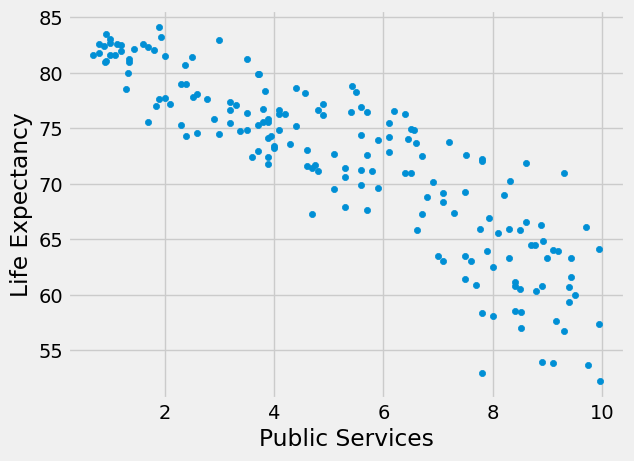

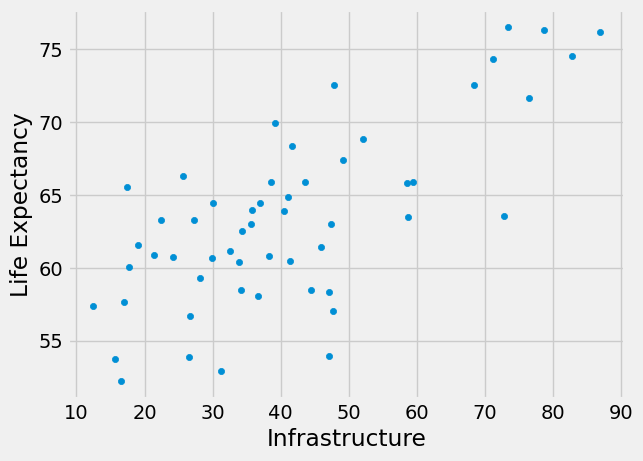

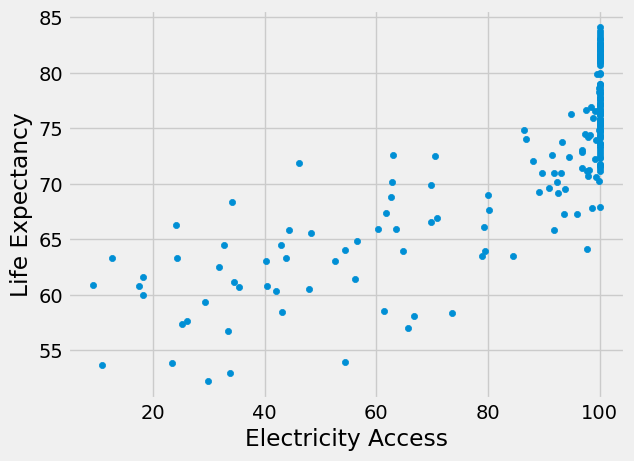

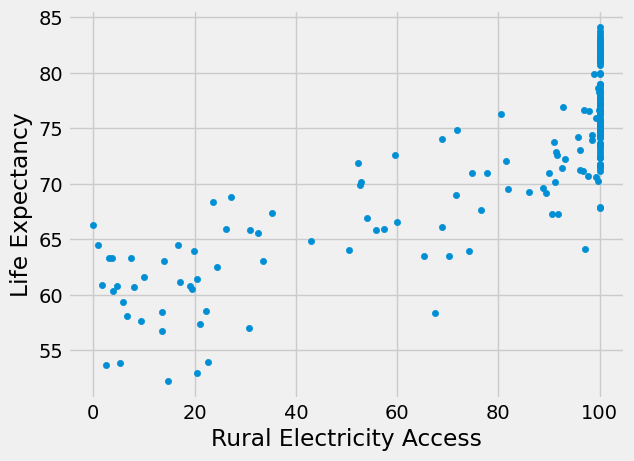

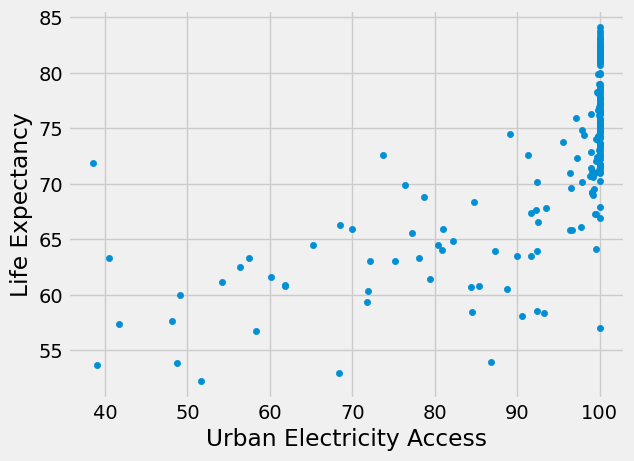

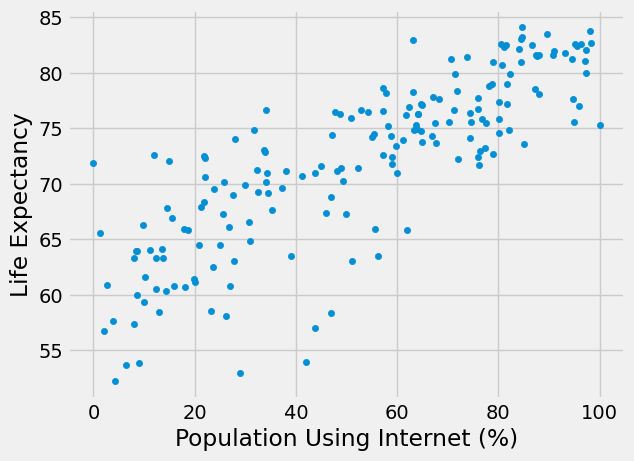

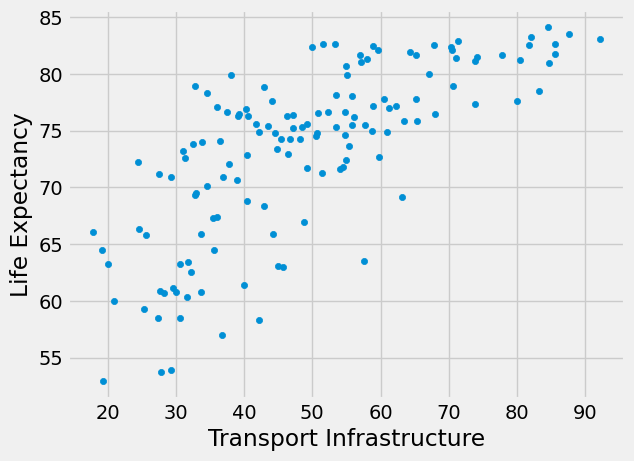

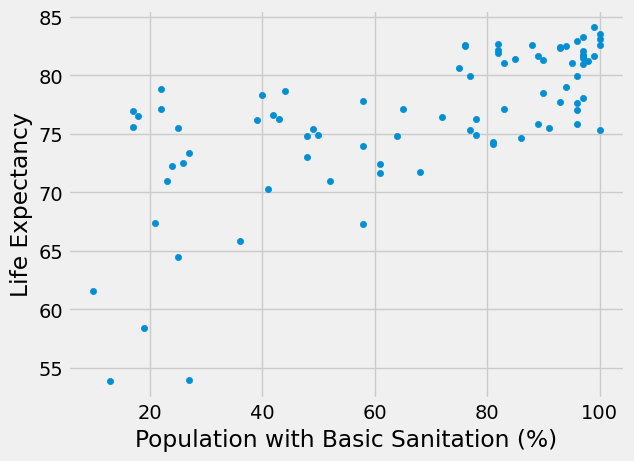

In [20]:
#Use the correlation function to compute all correlations at once
print_correlations(qog_data, infrastructure_vars,'Life Expectancy')

#this will show ALL the scatter plots for each variable, this is good for examining whether the relationships are linear or quadratic
print_scatter_plot(qog_data, infrastructure_vars, 'Life Expectancy')

Infrastructure plays a key role on life expectancy. Higher levels of investment into infrastructure leads to increased production of health services and therefore consumption of these services (Agénor, 2010). Agénor's (2010) model of infrastructure-led development suggests infrastructure to be one of the main drivers behind a country's health outcomes. Whilst access to clean water and sanitation has a clear link to improving health, access to electricity not only reduces the cost of boiling water (money which could be spent elsewhere) it reduces the use of smoke producing fuels (eg. wood), therefore lowering the indoor air pollution and incidence of respiratory illnesses (Wang, 2003; Wagstaff & Claeson, 2004).

We can see from above that there are strong positive correlations between life expectancy and the infrastructure, electricity access (total, rural and urban), population using internet, transport infrastructure and population with basic sanitation variables. Out of the electricity access variable we will only take forward 'electricity access' as this covers the variance of the other two which separate into rural and urban access. There was a strong negative correlation with life expectancy and public services. On further investigation into this variable we found it was part of the Fragile State Index (FSI), and covered a range of topics that our more specific variables already cover. Therefore, we did not take the public services variable forward for our model, but made a second model for life expectancy using the FSI, more on this later.

### Health:

Correlation with Life Expectancy for column =Environmental Health
0.8662646642648
Correlation with Life Expectancy for column =Subjective Health
-0.6100475878620719
Correlation with Life Expectancy for column =Human Development
0.7304923050066482
Correlation with Life Expectancy for column =Health
0.7444491221140621
Correlation with Life Expectancy for column =Policy Performance: Social Policies - Health
0.8053264482739966
Correlation with Life Expectancy for column =Human Development Index
0.9131319291560653
Correlation with Life Expectancy for column =Smoking Prevalence, Females (% of Adults)
0.48333825368694927
Correlation with Life Expectancy for column =Smoking Prevalence, Males (% of Adults)
0.08961703142997833
Correlation with Life Expectancy for column =State of Health
0.048156219100709004
Correlation with Life Expectancy for column =Comparative Abortion Index 2 (0 to 1)
0.42081357026527383
AxesSubplot(0.08,0.07;0.87x0.81)
AxesSubplot(0.08,0.07;0.87x0.81)
AxesSubplot(0.08,0.07;

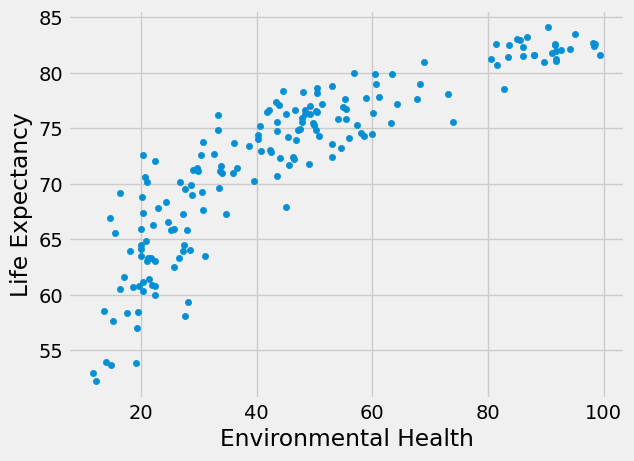

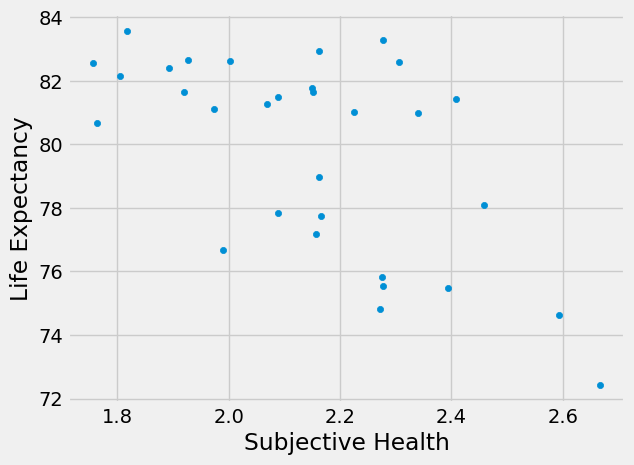

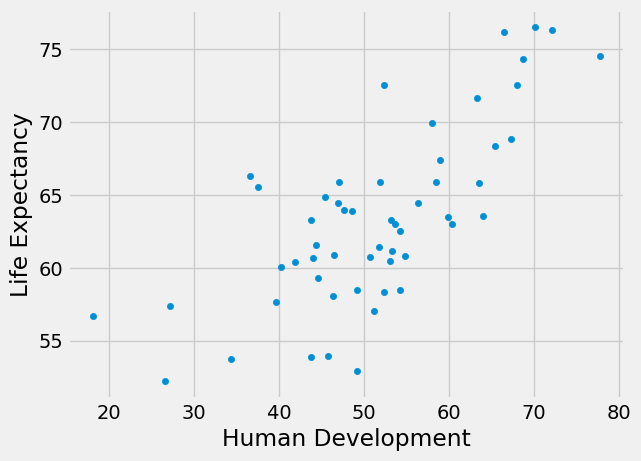

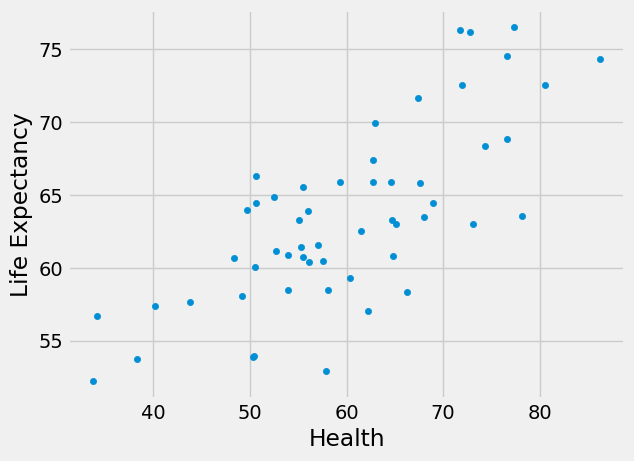

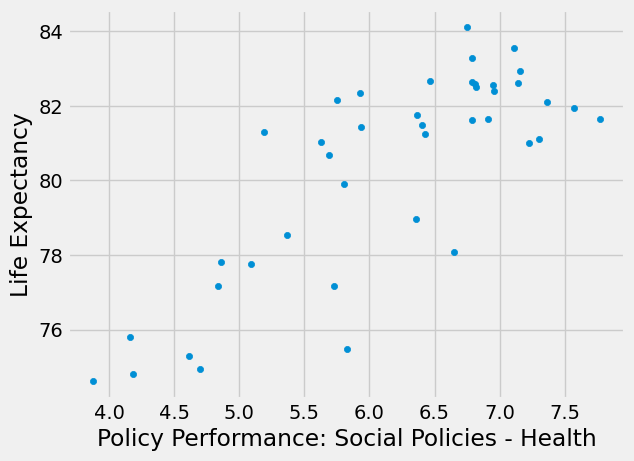

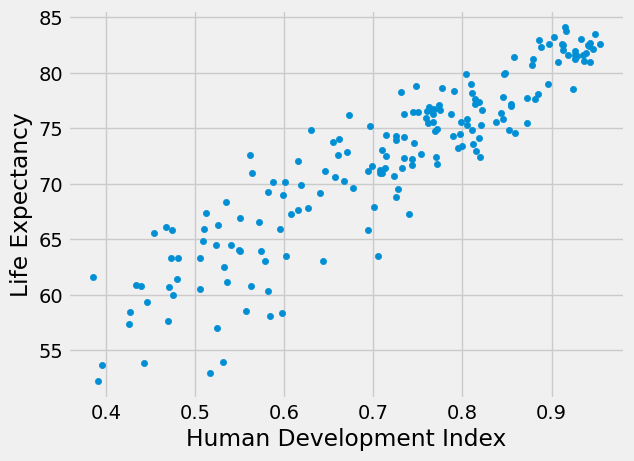

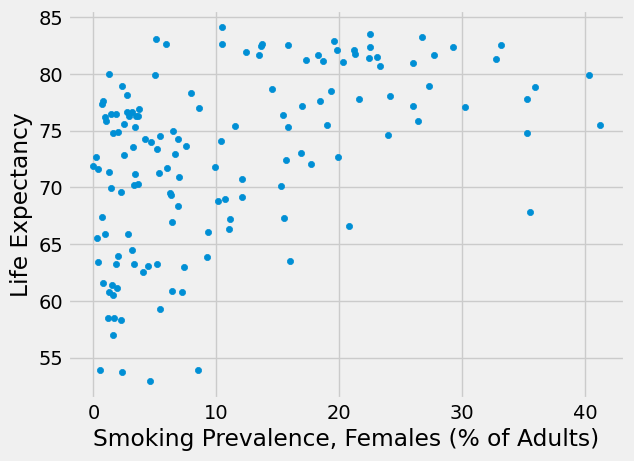

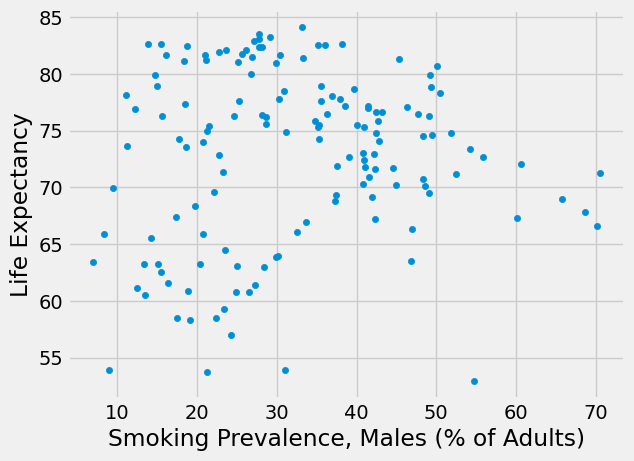

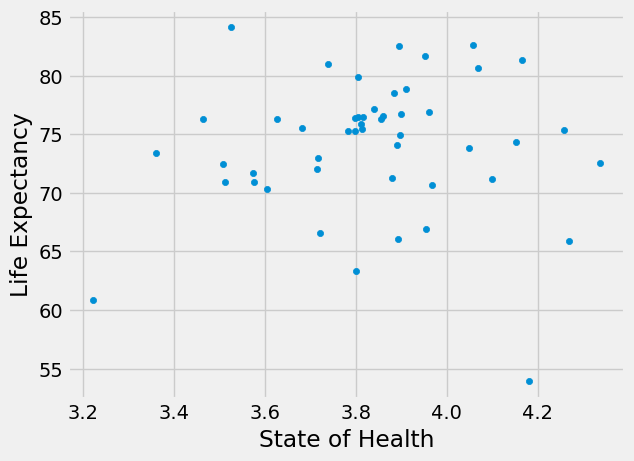

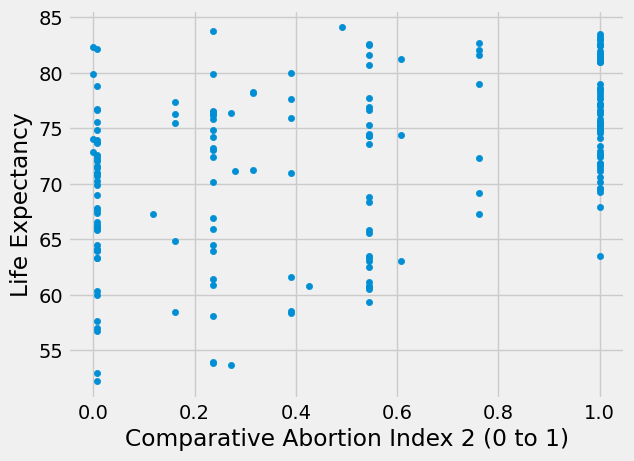

In [27]:
#Use the correlation function to compute all correlations at once
print_correlations(qog_data, health_vars,'Life Expectancy')

#this will show ALL the scatter plots for each variable, this is good for examining whether the relationships are linear or quadratic
print_scatter_plot(qog_data, health_vars, 'Life Expectancy')

Access to healthcare for individuals is paramount in reducing mortality. Research by Hao et al (2020), conducted a nationwide longitudinal survey in China and found that adequate access to healthcare was associated with longer life expectancy among older adults. They suggested that improving access to healthcare for older individuals could increase life expectancy in more rural areas where access to healthcare is poor. Their research highlights the importance of access to healthcare in increasing life expectancy. For this reason, we are including health variables in our model. Additionally, research into environmental health has found that environmental quality is an important factor in affecting health, in particular mortality. Variables such as air quality, water pollution, depletion of natural resources as well as soil deterioration have all been found to increase mortality (Pope et al, 2000; Pope et al 2004). Factors such as these can be improved in less economically developed countries and could have a large impact in increasing their average life expectancy. Both pieces of literature highlight the impact that societal healthcare issues have on life expectancy, and that improving access to health care or reducing pollution can positively impact individuals.

From the correlations between life expectancy and health variables, there appear to be high positive correlations with variables such as environmental health, human development index and, Policy Performance: Social Policies - Health. After visualising the environmental health variable, it appears that the data may not entirely fit a linear relationship, curving ever so slightly. We can examine the effect of environmental health better by transforming the variable in the checks for normality section below.

### Education:

Correlation with Life Expectancy for column =Expenditure on Primary Education
-0.5331976281080409
Correlation with Life Expectancy for column =Expenditure on Secondary Education
0.33586615959920924
Correlation with Life Expectancy for column =Expenditure on Tertiary Education
0.03489332948829859
Correlation with Life Expectancy for column =Primary School Enrollment
0.02427819872183772
Correlation with Life Expectancy for column =Secondary School Enrollment
0.8307310173924274
Correlation with Life Expectancy for column =Tertiary School Enrollment
0.7402651194830008
Correlation with Life Expectancy for column =Literacy Rate Total
0.7619771850667292
Correlation with Life Expectancy for column =Literacy Rate Female
0.751784455527764
Correlation with Life Expectancy for column =Literacy Rate Male
0.7593897992461826
AxesSubplot(0.08,0.07;0.87x0.81)
AxesSubplot(0.08,0.07;0.87x0.81)
AxesSubplot(0.08,0.07;0.87x0.81)
AxesSubplot(0.08,0.07;0.87x0.81)
AxesSubplot(0.08,0.07;0.87x0.81)
AxesSubplot(0

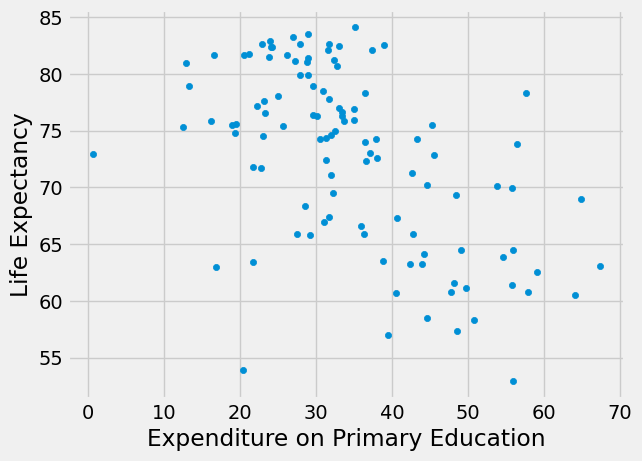

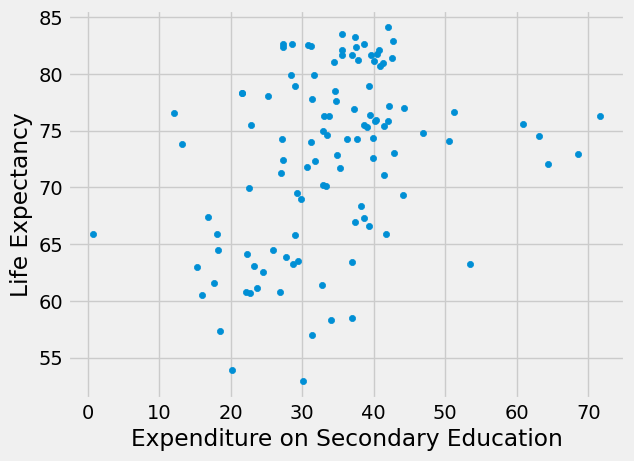

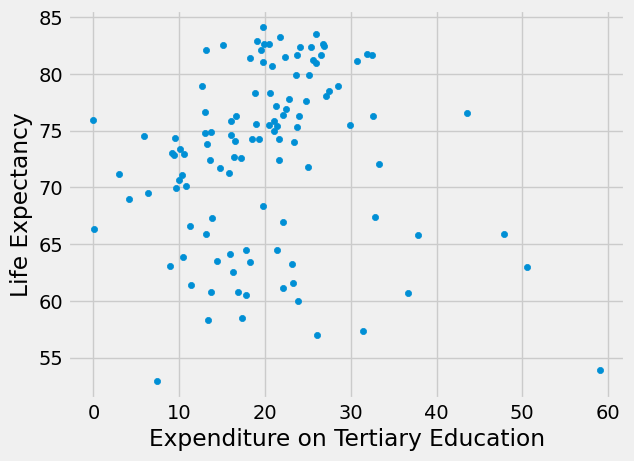

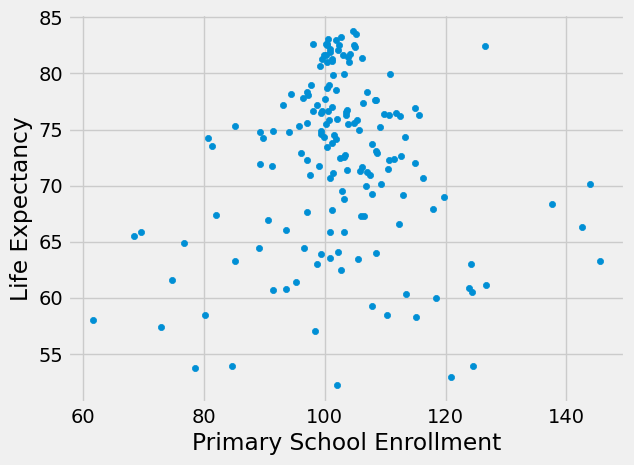

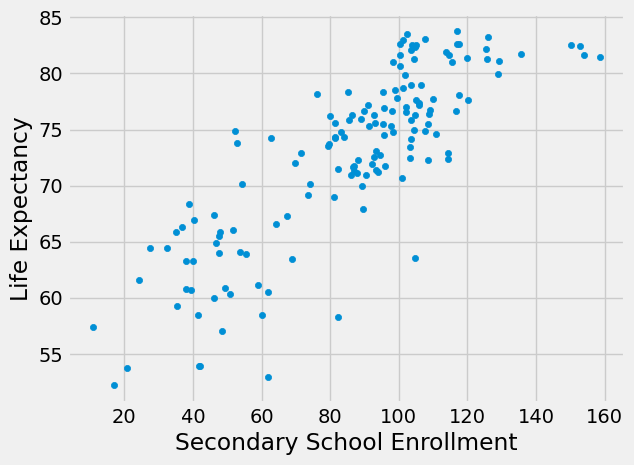

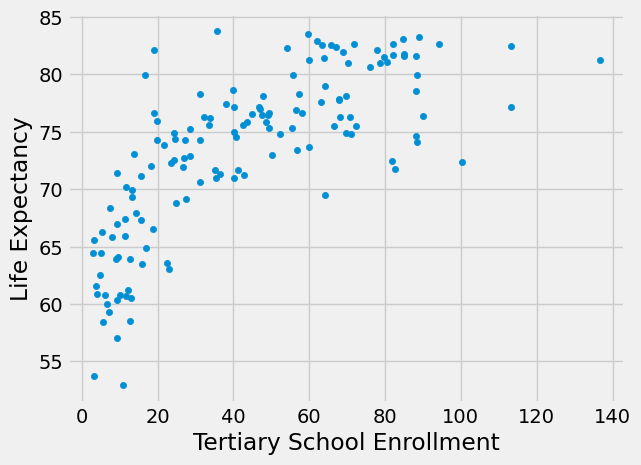

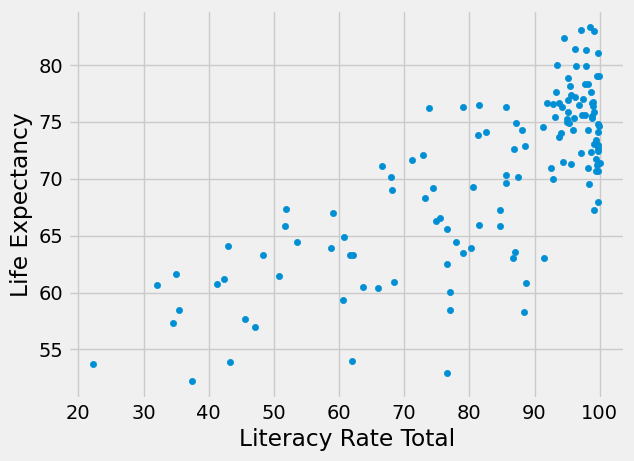

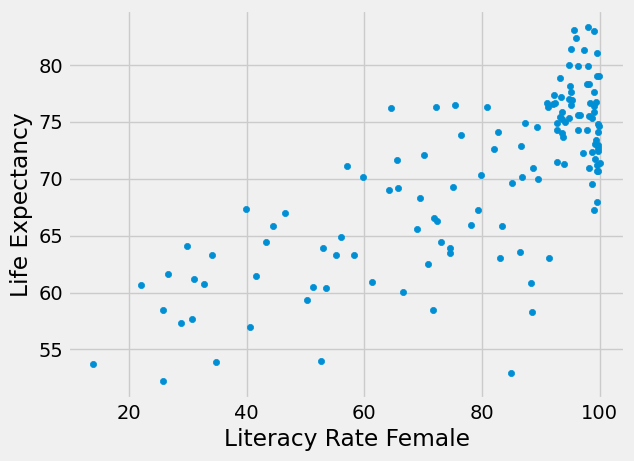

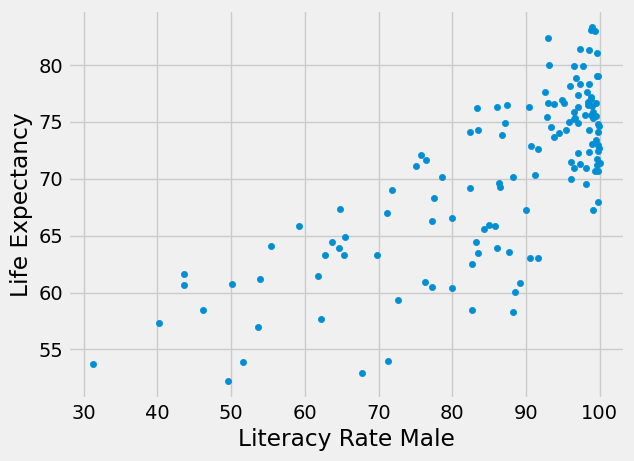

In [28]:
#Use the correlation function to compute all correlations at once
print_correlations(qog_data, education_vars,'Life Expectancy')

#this will show ALL the scatter plots for each variable, this is good for examining whether the relationships are linear or quadratic
print_scatter_plot(qog_data, education_vars, 'Life Expectancy')

The current literature suggests that education factors influence life expectancy. In a study by Luy et al. (2019), the researchers explore the influence of education on life expectancy in three populations from the USA, Denmark and Italy. They found that longevity increased for those who had more than secondary school education, and education contributed towards life expectancy in all three populations (between 1990 and 2010). More specifically, they found that changes in education contributed to life expectancy ranging from 15% for men in the USA, to 40% for women from Denmark. Furthermore, Lutz et al. (2018) completed a study using data from 1970-2015 and 175 countries, and found there was a stronger correlation with longevity and education, as opposed to income. They argue that improved education leads to better income and improved health. Based on the current literature, we chose to explore the impact of expenditure on education, school enrolment and literacy rate on life expectancy.

From correlations between these variables in the dataset and life expectancy, we can see that there are weak positive correlations between life expectancy and secondary/tertiary school expenditure and enrolment in primary school. There is a medium negative correlation between expenditure in primary school and life expectancy. There are strong positive correlations for the following factors with life expectancy: enrolment in secondary and tertiary school, literacy rates in males and females and total literacy rate. Therefore, these factors will be considered for the regression model. Tertiary school enrolment does not look like a linear relationship from the graphs and hence we will log transform this data for our regression model.

### Environment:

Correlation with Life Expectancy for column =Threatened Species
0.04221077350943037
Correlation with Life Expectancy for column =Sustainability
0.6969101499415743
Correlation with Life Expectancy for column =Total Ecological Footprint of Consumption
0.6173017797029603
Correlation with Life Expectancy for column =The Region of the Country
-0.03752970948865014
Correlation with Life Expectancy for column =Latitude
0.5887941470353572
Correlation with Life Expectancy for column =Average Distance to Ice-Free Coast
-0.2666187629772629
Correlation with Life Expectancy for column =Land Area
0.05862417763523648
Correlation with Life Expectancy for column =CO2 Emissions
0.45734701891951746
AxesSubplot(0.08,0.07;0.87x0.81)
AxesSubplot(0.08,0.07;0.87x0.81)
AxesSubplot(0.08,0.07;0.87x0.81)
AxesSubplot(0.08,0.07;0.87x0.81)
AxesSubplot(0.08,0.07;0.87x0.81)
AxesSubplot(0.08,0.07;0.87x0.81)
AxesSubplot(0.08,0.07;0.87x0.81)
AxesSubplot(0.08,0.07;0.87x0.81)


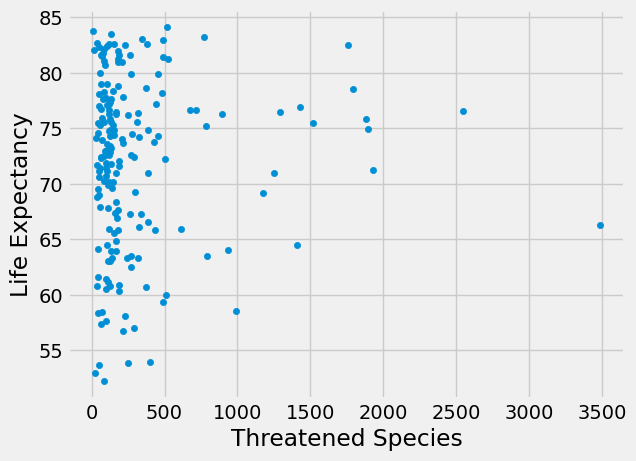

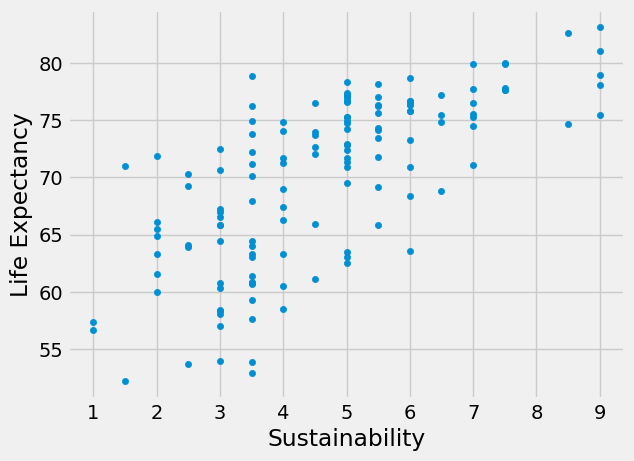

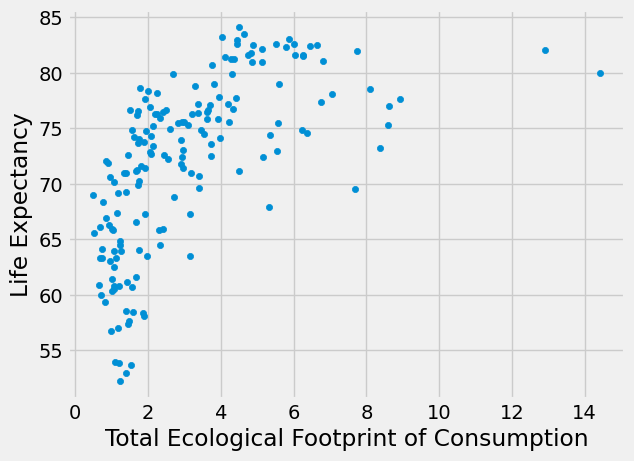

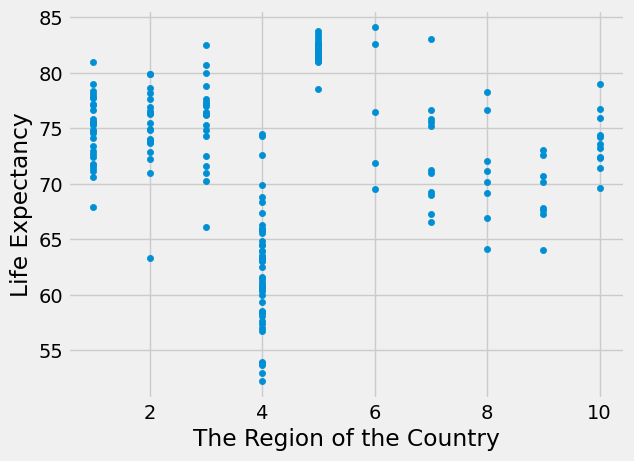

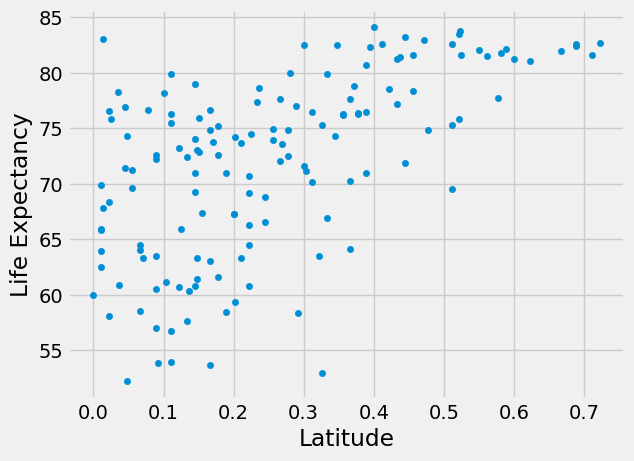

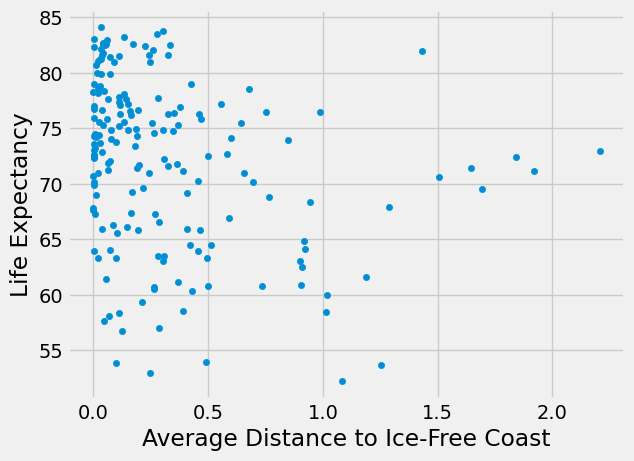

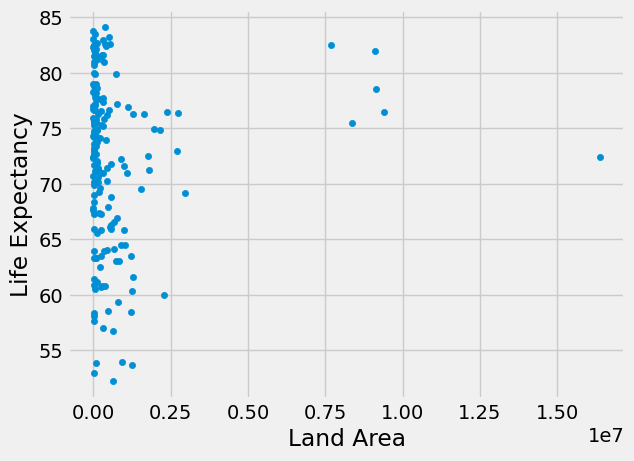

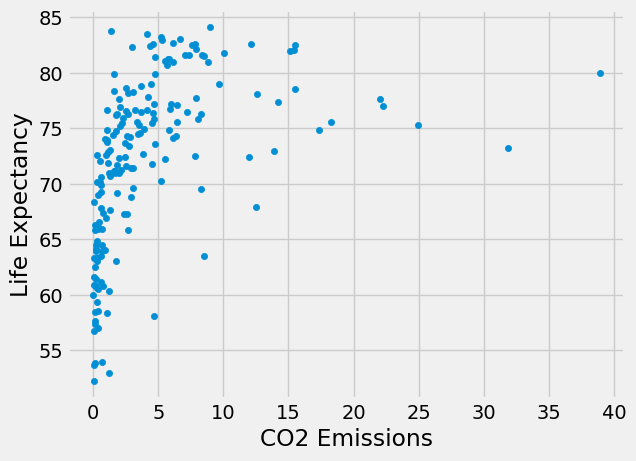

In [29]:
#Use the correlation function to compute all correlations at once
print_correlations(qog_data, environment_vars,'Life Expectancy')

#this will show ALL the scatter plots for each variable, this is good for examining whether the relationships are linear or quadratic
print_scatter_plot(qog_data, environment_vars, 'Life Expectancy')

As mentioned previously, environmental factors are known to influence life expectancy. As we can see from the plots above, there are medium correlations between Latitude, Sustainability and Total Ecological Footprint of Consumption and therefore these variables will be taken forward further for the multi-regression model. A study conducted by Borisenkov (2011) which investigated factors affecting cancer incidence and life expectancy has shown that latitude was the strongest predictor of cancer incidence and mortality as it explained 46% and 50% of the variability, respectively. This shows one way in which latitude may modulate life expectancy. Additionally, there is a positive, non-linear correlation displayed between total-ecological footprint of consumption and life expectancy, this may be explained by literature which has shown that an increasing demand on natural resources in a population does improve life expectancy however at a certain level there may be an over demand on resource where a population can no longer be sustained efficiently. This may explain why life expectancy tails off on the graph (Streimikiene, 2015). Finally, another strong positive non-linear correlation was observed between CO2 emissions and life expectancy which may be explained by CO2 as an indirect measurement of country wealth (Gaziyev, 2017). More specifically, an increase in a countries carbon dioxide emissions reflect greater industrialisation and economic growth which in turn allows for a greater investment of money into the healthcare system and improving life expectancy. However, with increasingly high levels of CO2 emissions, the air pollution levels worsen which will hinder an individuals health and so this may explain why life expectancy tails off with a certain CO2 level.

## Checks for normality

The assumptions of multiple regression include: linear relationships, normal distribution and no multi-colinearity. Based on the scatterplots above, we decided to log transform some of our variables to improve linear relationships between our variables and life expectancy.

Correlation with Life Expectancy for column =Log of Environmental Health
0.9153178796910224
Correlation with Life Expectancy for column =Log of Tertiary School Enrollment
0.8197741398349527
Correlation with Life Expectancy for column =Log of Total Ecological Footprint of Consumption
0.7135257499615413
None


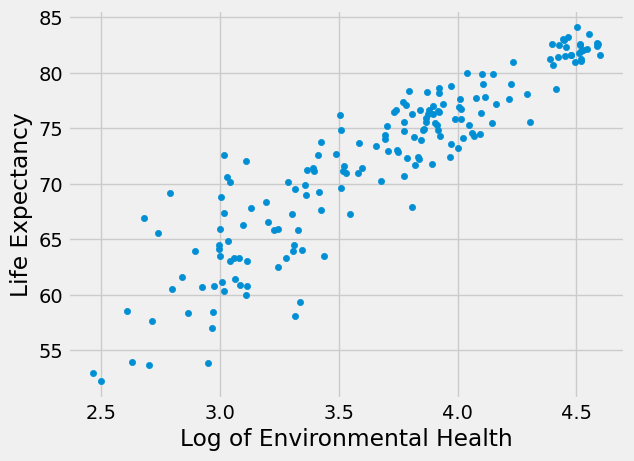

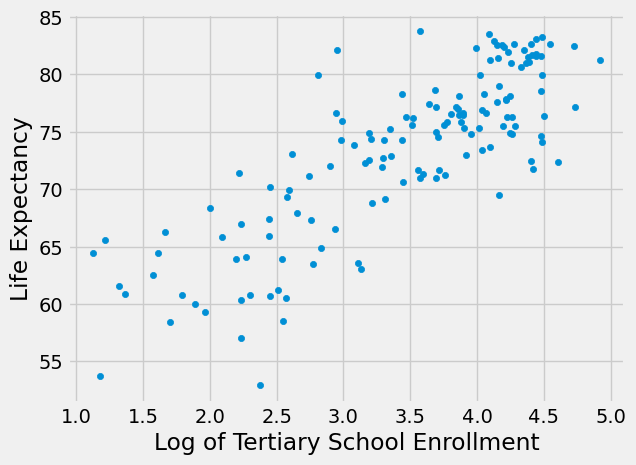

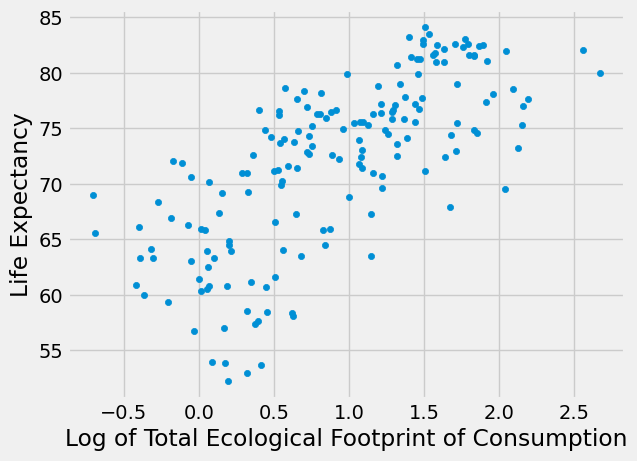

In [30]:
#Transformations of Variables
transformation_of_column(qog_data, 'Environmental Health','Log of Environmental Health',log)
transformation_of_column(qog_data, 'Tertiary School Enrollment','Log of Tertiary School Enrollment',log)
transformation_of_column(qog_data, 'Total Ecological Footprint of Consumption', 'Log of Total Ecological Footprint of Consumption', log)

list_transformed_vars = ['Log of Environmental Health','Log of Tertiary School Enrollment', 'Log of Total Ecological Footprint of Consumption']
print(print_correlations(qog_data, list_transformed_vars,'Life Expectancy'))

Next we checked for normality using histograms and Shapiro wilks test using information from the following resource. (https://towardsdatascience.com/is-normal-distribution-necessary-in-regression-how-to-track-and-fix-it-494105bc50dd).

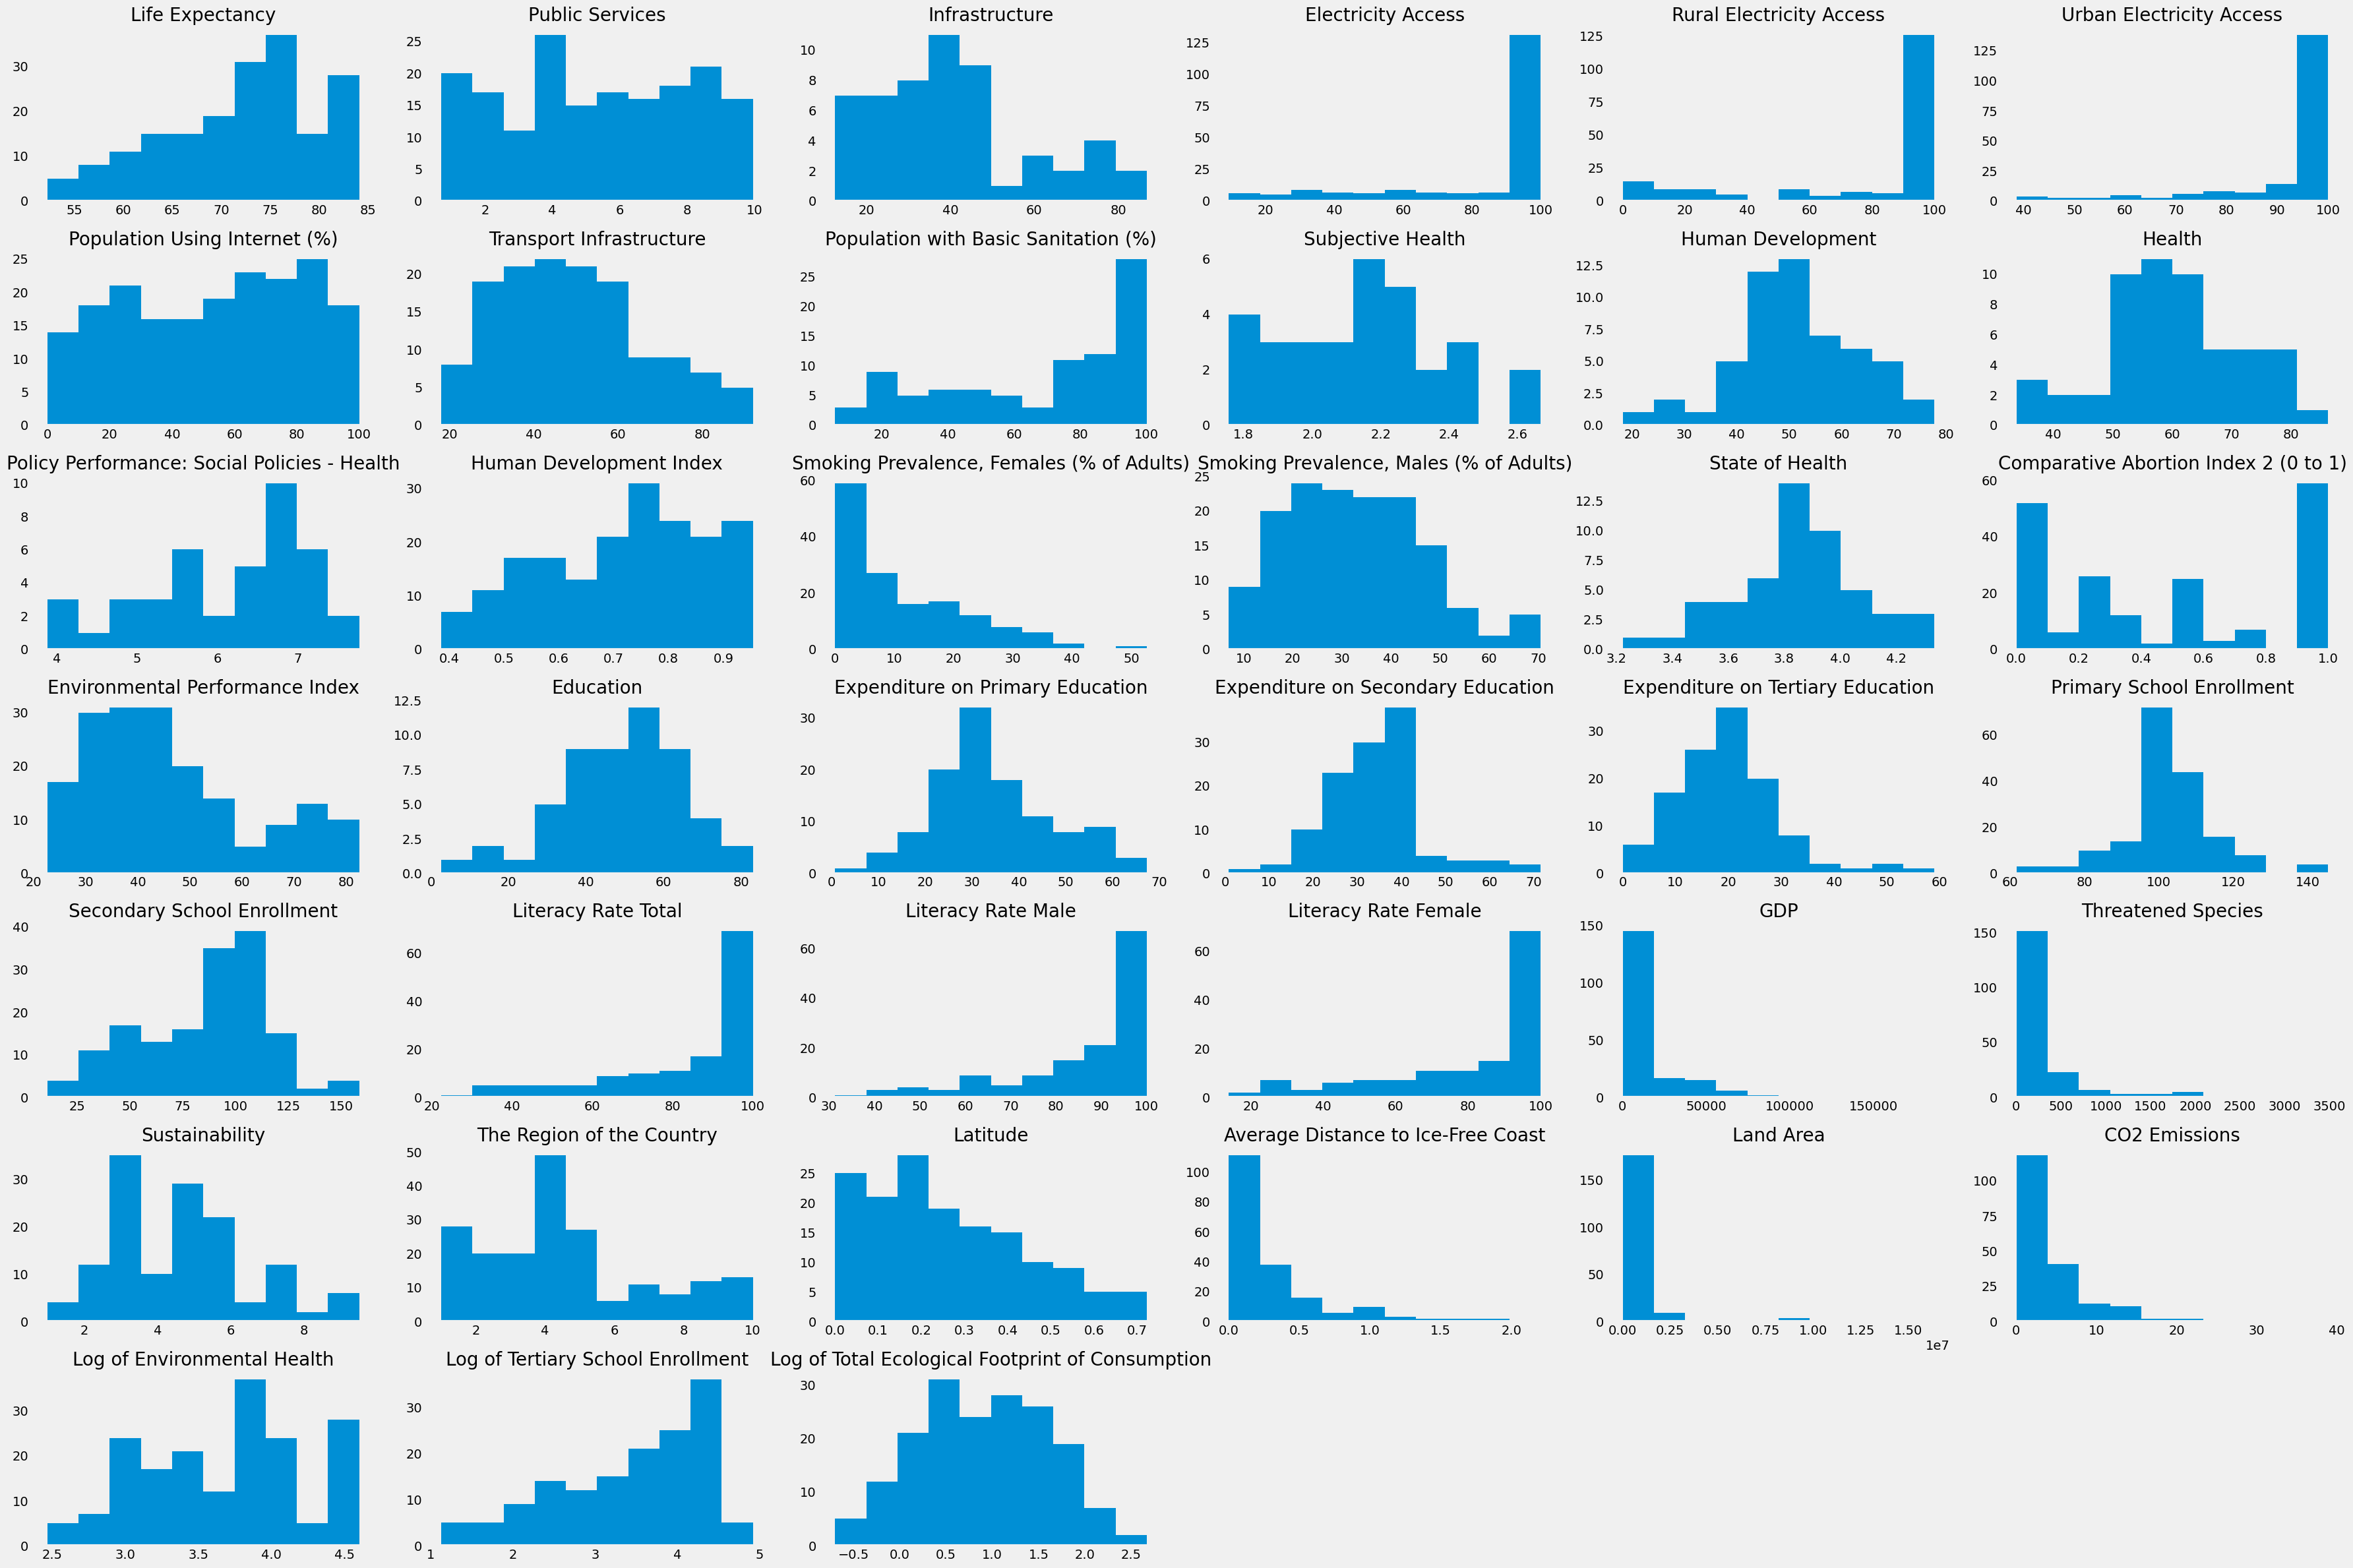

In [55]:
ax_arr = qog_data.hist(figsize=(36,24), grid=False)
# Set the title font size
for ax in ax_arr.flatten():
    title = ax.get_title()
    ax.set_title(title, fontsize=20)
# Improve the layout and prevent overlap
plt.tight_layout()

plt.show()

In [56]:
def test_for_normality(df, column_name):
    var= df[column_name].dropna()
    test = stats.shapiro(var)
    print(column_name, test)

In [57]:
print(test_for_normality(qog_data, 'Log of Tertiary School Enrollment'))
print(test_for_normality(qog_data, 'Secondary School Enrollment'))
print(test_for_normality(qog_data, 'Literacy Rate Total'))
print(test_for_normality(qog_data, 'Electricity Access'))
print(test_for_normality(qog_data, 'Population Using Internet (%)'))
print(test_for_normality(qog_data, 'Latitude'))
print(test_for_normality(qog_data, 'Log of Total Ecological Footprint of Consumption'))
print(test_for_normality(qog_data, 'Log of Environmental Health'))

Log of Tertiary School Enrollment ShapiroResult(statistic=0.9307974576950073, pvalue=1.4016065961186541e-06)
None
Secondary School Enrollment ShapiroResult(statistic=0.96547931432724, pvalue=0.0006079183658584952)
None
Literacy Rate Total ShapiroResult(statistic=0.8184139132499695, pvalue=9.850347967854667e-12)
None
Electricity Access ShapiroResult(statistic=0.6760631203651428, pvalue=4.986797392516413e-19)
None
Population Using Internet (%) ShapiroResult(statistic=0.9505563378334045, pvalue=3.2920918329182314e-06)
None
Latitude ShapiroResult(statistic=0.9469411373138428, pvalue=1.526206688140519e-05)
None
Log of Total Ecological Footprint of Consumption ShapiroResult(statistic=0.9879257082939148, pvalue=0.14003586769104004)
None
Log of Environmental Health ShapiroResult(statistic=0.9672991037368774, pvalue=0.00031583744566887617)
None


Only one variable, Ecological Footprint of Consumption (log) met the assumptions for normality. Consequently, a large limitation of our study is that the variables do not meet normality. If we had more time, exploring the distribution of the error after the model may have allowed us to improve the reliability of our model.

## Is it all down to money?

Many studies suggest that wealth has the greatest influence on life expectancy (Chetty et al., 2016). With individuals from countries with higher GDP's often living longer, due to more investment in healthcare systems. However there are large inconsistencies between income and predicted life expectancy based on income. Projects such as "Punching Above Their Weight Network" in 2017 have hence been formed to explore why some countries have shorter or longer life expectancies than would be predicted solely based on income/wealth.

(https://www.flinders.edu.au/southgate-institute-health-society-equity/punching-above-weight-network#:~:text=In%20September%202017%20the%20Punching,predicted%20by%20their%20economic%20status.)

A study by Freeman et al, (2020) suggests that factors such as female education, health care and political participation may contribute to increased life expectancy in Ethiopia, USA and Brazil, for example.

Pearson's r for GDP and life expectancy: 0.6428261278966615
AxesSubplot(0.08,0.07;0.87x0.81)


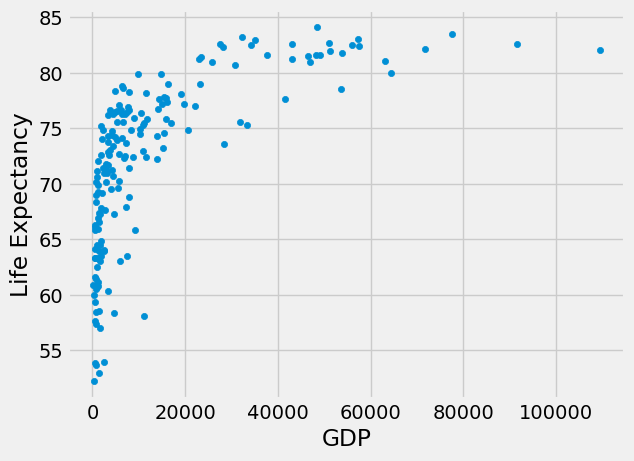

In [58]:
#GDP correlation with life expectancy 
print("Pearson's r for GDP and life expectancy:", extract_correlate(qog_data, 'GDP', 'Life Expectancy'))
print(qog_data.plot.scatter('GDP','Life Expectancy'))

As you can see there is a nonlinear relationship between GDP and life expectancy. This seems intuitive as the main factors for life expectancy in poorer countries would be governed by the relative wealth available to those countries, such as quality and access to healthcare. However, once a certain level of wealth is reached one can expect a certain standard of healthcare, sanitation and other variables that would have direct impact on life expectancy, hence we see the relationship of GDP and life expectancy tapers. This could mean that other variables may explain the difference in the life expectancy for the more wealthy countries where these standards have been met, whereas wealth could be the driving factor in the poorer countries.

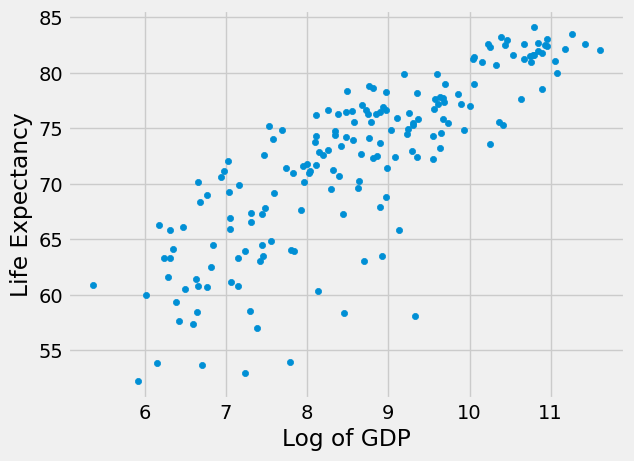

In [60]:
transformation_of_column(qog_data,'GDP','Log of GDP',log)

(array([ 3., 18., 20., 23., 31., 35., 22., 17., 16.,  2.]), array([ 5.36662651,  6.04341353,  6.72020054,  7.39698756,  8.07377458,
        8.75056159,  9.42734861, 10.10413562, 10.78092264, 11.45770965,
       12.13449667]), <BarContainer object of 10 artists>)
Log of GDP ShapiroResult(statistic=0.9838194847106934, pvalue=0.029595624655485153)
None


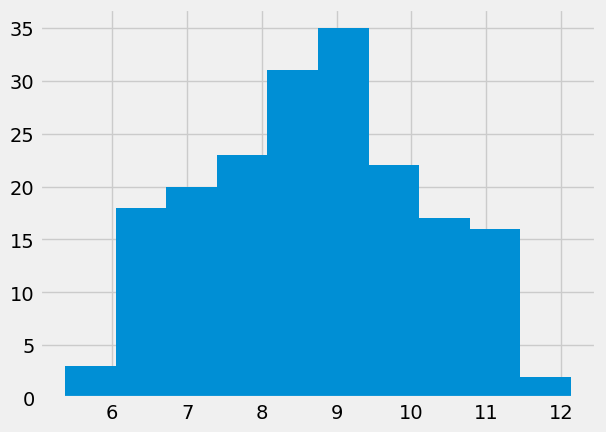

In [61]:
print(plt.hist(qog_data['Log of GDP']));
print(test_for_normality(qog_data, 'Log of GDP'))

## Finalising the data for our model: which variables are we taking forward for predicting Life Expectancy?

From exploring the dataset it is clear that there are variables which are more strongly correlated with life expectancy than others such as: environmental health and tertiary school enrollment. Ideally we would like to take all of these variables forward into our multi-linear regression model, however, it is important to note that there are missing values which need to be dealt with. One way to deal with missing values is to take the variables forward which have fewer than 30% of their data missing and infill an average value for the missing data.

Let's&nbsp;explore&nbsp;which&nbsp;of&nbsp;our&nbsp;strongly&nbsp;correlated&nbsp;variables&nbsp;have&nbsp;30%&nbsp;or less&nbsp;of&nbsp;their&nbsp;data&nbsp;missing.

In [62]:
"""Counting missing values: which variables should we exclude from our multiple regression model 
and which should we impute?"""
qog_data.isna().sum()

"""Calculating the percentage of missing values for each variable columns. We will put variables into the model
which have 30% or less of their variables missing"""
percent_missing = qog_data.isnull().sum() * 100 / len(qog_data)
missing_value_df = pd.DataFrame({'column_name': qog_data.columns,'percent_missing':percent_missing})
missing_value_df.sort_values('percent_missing', inplace=True)

"""Return a list of those variables which meet our criteria"""
col_vars = list(missing_value_df[missing_value_df['percent_missing']<=30]['column_name'])
print(col_vars)

['The Region of the Country', 'Threatened Species', 'Electricity Access', 'Population Using Internet (%)', 'Comparative Abortion Index 2 (0 to 1)', 'Land Area', 'Rural Electricity Access', 'Urban Electricity Access', 'Average Distance to Ice-Free Coast', 'CO2 Emissions', 'Log of GDP', 'Human Development Index', 'Life Expectancy', 'Log of Environmental Health', 'Environmental Performance Index', 'Public Services', 'Log of Total Ecological Footprint of Consumption', 'Primary School Enrollment', 'Secondary School Enrollment', 'Latitude', 'Smoking Prevalence, Females (% of Adults)', 'Smoking Prevalence, Males (% of Adults)', 'Log of Tertiary School Enrollment', 'Transport Infrastructure', 'Literacy Rate Female', 'Literacy Rate Male', 'Literacy Rate Total', 'Sustainability']


We are now ready to create a final data frame for all the variables we will use for our model, data was selected on a threshold of under 30% of their available data was missing when compared with life expectancy.

In [63]:
"""Final columns - GDP"""
#create dataframe for relevant variables 
qog_model_df = pd.DataFrame()
qog_model_df['Life Expectancy'] = qog_data['Life Expectancy']
qog_model_df['Log of Tertiary School Enrollment'] = qog_data['Log of Tertiary School Enrollment']
qog_model_df['Secondary School Enrollment'] = qog_data['Secondary School Enrollment']
qog_model_df['Literacy Rate Total'] = qog_data['Literacy Rate Total'] 
qog_model_df['Electricity Access'] = qog_data['Electricity Access']
qog_model_df['Population Using Internet (%)'] = qog_data['Population Using Internet (%)']
qog_model_df['Transport Infrastructure'] = qog_data['Transport Infrastructure']
qog_model_df['Log of Total Eco Footprint of Consumption'] = qog_data['Log of Total Ecological Footprint of Consumption']
qog_model_df['Latitude'] = qog_data['Latitude']
qog_model_df['Log of Environmental Health'] = qog_data['Log of Environmental Health']
qog_model_df['Log of GDP'] = qog_data['Log of GDP']
qog_model_df.head()

,Life Expectancy,Log of Tertiary School Enrollment,Secondary School Enrollment,Literacy Rate Total,Electricity Access,Population Using Internet (%),Transport Infrastructure,Log of Total Eco Footprint of Consumption,Latitude,Log of Environmental Health,Log of GDP
cname,,,,,,,,,,,
Afghanistan,64.129997,2.270725,53.643200,43.019718,97.699997,13.500000,NaN,-0.319170,0.366667,2.995732,6.348161
Albania,78.333000,4.049613,95.265892,98.141151,100.000000,71.847000,34.536278,0.697043,0.455556,3.795489,8.489680
Algeria,76.499001,3.863816,NaN,81.407837,100.000000,47.691101,39.287235,0.878513,0.311111,3.919991,8.474784
Andorra,NaN,NaN,NaN,NaN,100.000000,91.567497,NaN,NaN,0.470000,NaN,10.701687
Angola,60.379002,2.233906,50.671478,66.030113,41.962894,14.339100,31.648005,0.014442,0.136667,3.015535,8.134447


Next, we dropped all the countries which have a missing life expectancy value and fill the missing values for the predictor variables for our model with an average value.

In [64]:
#Drop empty life_xp rows and Fill NAN for the rest
qog_model_df.dropna(subset=['Life Expectancy'],inplace=True)
qog_model_df.fillna(qog_model_df.mean(), inplace=True)
qog_model_df.isna().sum()

Life Expectancy                              0
Log of Tertiary School Enrollment            0
Secondary School Enrollment                  0
Literacy Rate Total                          0
Electricity Access                           0
Population Using Internet (%)                0
Transport Infrastructure                     0
Log of Total Eco Footprint of Consumption    0
Latitude                                     0
Log of Environmental Health                  0
Log of GDP                                   0
dtype: int64

For completeness, we checked the multicolinearity assumptions, inspired by code from the following source (https://towardsdatascience.com/multi-collinearity-in-regression-fe7a2c1467ea). As you can see below, some of our variables are highly correlated, which reduces the reliability of our model.

In [65]:
#creating a correlation matrix between variables
correlations =qog_model_df.corr()
correlations.style.background_gradient(cmap='coolwarm')

,Life Expectancy,Log of Tertiary School Enrollment,Secondary School Enrollment,Literacy Rate Total,Electricity Access,Population Using Internet (%),Transport Infrastructure,Log of Total Eco Footprint of Consumption,Latitude,Log of Environmental Health,Log of GDP
Life Expectancy,1.000000,0.682260,0.755685,0.622996,0.810153,0.822372,0.623341,0.699456,0.559620,0.888185,0.805949
Log of Tertiary School Enrollment,0.682260,1.000000,0.731109,0.545621,0.674420,0.696550,0.553969,0.624496,0.471245,0.727083,0.696916
Secondary School Enrollment,0.755685,0.731109,1.000000,0.647979,0.727334,0.725018,0.549559,0.661667,0.512548,0.757124,0.769172
Literacy Rate Total,0.622996,0.545621,0.647979,1.000000,0.716983,0.566774,0.281409,0.484106,0.159115,0.553319,0.555940
Electricity Access,0.810153,0.674420,0.727334,0.716983,1.000000,0.751321,0.475017,0.648430,0.409735,0.707185,0.696608
Population Using Internet (%),0.822372,0.696550,0.725018,0.566774,0.751321,1.000000,0.585567,0.803279,0.546848,0.828839,0.868688
Transport Infrastructure,0.623341,0.553969,0.549559,0.281409,0.475017,0.585567,1.000000,0.609203,0.485634,0.642903,0.703643
Log of Total Eco Footprint of Consumption,0.699456,0.624496,0.661667,0.484106,0.648430,0.803279,0.609203,1.000000,0.479718,0.753167,0.840177
Latitude,0.559620,0.471245,0.512548,0.159115,0.409735,0.546848,0.485634,0.479718,1.000000,0.581173,0.575480
Log of Environmental Health,0.888185,0.727083,0.757124,0.553319,0.707185,0.828839,0.642903,0.753167,0.581173,1.000000,0.865857


Next we made a function that will split our final dataframe into training and testing sets and created a multiple regression model using the training data set.

In [68]:
def shuffle_split(df):
    """ 
    Splitting the dataframe into 80:20 training:testing sets.
    """
    n_rows = len(df)
    shuffled = df.sample(n_rows, replace=False)
    training = shuffled.iloc[:int(n_rows*0.8)]
    testing = shuffled.iloc[int(n_rows*0.8):]
    return training, testing

In [69]:
qog_training, qog_testing = shuffle_split(qog_model_df)

We then made a function that takes a training dataframe and computes a multiple regression model for life expectancy using Statsmodel.

In [70]:
def mlr(df):
    """ A function that takes a country-name-indexed dataframe with a 'Life Epectancy' column as well as other predictor 
    variable columns. It returns a multiple linear regression model for 'Life Expectancy' using StatsModels. """
    columns = list(df.columns)
    columns.remove('Life Expectancy')
    X = df[columns]
    y = df['Life Expectancy']
    ## fit a OLS model with intercept on variables
    X = sm.add_constant(X)
    return sm.OLS(y, X).fit()

In [74]:
# Train the model
qog_model = mlr(qog_training)
qog_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        Life Expectancy   R-squared:                       0.883
Model:                            OLS   Adj. R-squared:                  0.874
Method:                 Least Squares   F-statistic:                     102.5
Date:                Thu, 04 May 2023   Prob (F-statistic):           2.98e-58
Time:                        19:15:02   Log-Likelihood:                -354.50
No. Observations:                 147   AIC:                             731.0
Df Residuals:                     136   BIC:                             763.9
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
=============================================================================================================
                                                coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------------
const                                        34.2741      3.016     11.366      0.000      28.311      40.238
Log of Tertiary School Enrollment            -0.9291      0.493     -1.885      0.062      -1.904       0.046
Secondary School Enrollment                   0.0174      0.017      1.001      0.318      -0.017       0.052
Literacy Rate Total                           0.0219      0.024      0.916      0.361      -0.025       0.069
Electricity Access                            0.1083      0.018      6.150      0.000       0.073       0.143
Population Using Internet (%)                 0.0488      0.019      2.564      0.011       0.011       0.086
Transport Infrastructure                      0.0634      0.022      2.869      0.005       0.020       0.107
Log of Total Eco Footprint of Consumption    -0.9811      0.620     -1.581      0.116      -2.208       0.246
Latitude                                      2.8977      1.918      1.511      0.133      -0.894       6.690
Log of Environmental Health                   8.4684      1.009      8.396      0.000       6.474      10.463
Log of GDP                                   -0.9391      0.484     -1.939      0.055      -1.897       0.019
==============================================================================
Omnibus:                        6.777   Durbin-Watson:                   2.074
Prob(Omnibus):                  0.034   Jarque-Bera (JB):               10.773
Skew:                          -0.140   Prob(JB):                      0.00458
Kurtosis:                       4.296   Cond. No.                     2.26e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.26e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

As our F test was significant (p < .001) meaning we can deem that our R squared value is fairly reliable in telling us how much of the variance in our test data can be explained by the model. Our R sqaured value for this model is around 0.85 and so we can say this is a fairly accurate model as it can explain 85% of the variance in the data for the test set. Furthermore the adjusted R squared is also high with around the value of 0.850, this means that our model can explain roughly 85% of the variance in the general population.

Note: Re-running the model and consequently re-shuffling the traing and testing sets will alter the significance values for the variables. For example, the significance values for Log of Tertiary Enrollment and Population using Internet (%) may change. This is a potential caveat with our model.

We can only suggest that a number of variables within the model appear to be close to or significant in predicting life expectancy. This model could be improved with a more complete QoG dataset, with exact values for the measures used within the model as this would give conclusive insight into the relative significance of our model variables in predicting life expectancy.

Following this, we tested the model of the testing set, whereby we created a function that takes the test set and model, predicts the life expectancies and then computes the root mean squared error (rmse) value. This gives us an idea of the accuracy of our model.

In [75]:
def test_mlr_model(df, model):
    """ A function that takes a test set and life expectancy model and computes the RMSE value."""
    #Remove 'Life Expectancy' column
    columns = list(df.columns)
    columns.remove('Life Expectancy')
    Z = df[columns]
    # Use OLS model to predict life expectancies
    Z = sm.add_constant(Z)
    predicted = model.predict(Z)
    true_values = df['Life Expectancy']
    errors = true_values - predicted
    return np.sqrt(np.mean(errors ** 2))

In [76]:
# Test the model
qog_rmse = test_mlr_model(qog_testing, qog_model)
qog_rmse

3.0237052883100475

The model has an RMSE value between 1-4 when applied to the test set, this value in comparison to our data, which ranges up to 80 years, is relatively small fluctuation. This suggests that our model is fairly accurate in predicting global life expectancy.

## Fragile State Index Model

On further investigation into the 'Public Services' variable we found that it is a part of The Fund For Peace's Fragile States Index (FSI; https://fragilestatesindex.org/). The FSI is a scale from 0-120 that depcits how 'fragile' a state is, with a higher score indicating higher fragility. The scale is broken up into 12 different variables, all scored from 0-10. These variables score each state on more specific areas that they consider to come under each variables category. This led to us finding that the 'Public Services' variable covered a wide range of topics that overlapped with some of our other, more specific, variables and so for our model we decided to exclude it. For more information on what each of the 12 categories score on look here: https://fragilestatesindex.org/indicators/

The overall FSI score is also in our original dataset so we decided to correlate it with life expectancy to see if it could serve as another good predictor.

In [79]:
# Correlate FSI Score with Life Expectancy
correlation(all_qog_data, 'ffp_fsi', 'wdi_lifexp')

-0.8122969716952759

<AxesSubplot:xlabel='ffp_fsi', ylabel='wdi_lifexp'>

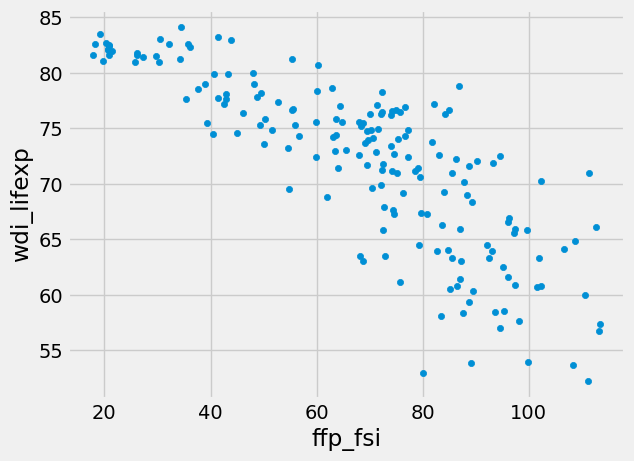

In [80]:
# Plot on a scatter graph
all_qog_data.plot.scatter('ffp_fsi', 'wdi_lifexp')

As you can see above, the FSI has a strong negative correlation with life expectancy. This led us to the idea to make a second model for life expectancy with the 12 variables in the FSI so that we could compare it with our model from our more specific variables.

Not all the variables in the FSI are in our QoG dataframe and so we need to get the complete FSI dataframe and merge it with the life expectancy data from the QoG dataframe:

In [81]:
# Read in the file
ffp_fsi = pd.read_csv('fsi-2021.csv')
ffp_fsi.head()

,Country,Year,Rank,Total,C1: Security Apparatus,C2: Factionalized Elites,C3: Group Grievance,E1: Economy,E2: Economic Inequality,E3: Human Flight and Brain Drain,P1: State Legitimacy,P2: Public Services,P3: Human Rights,S1: Demographic Pressures,S2: Refugees and IDPs,X1: External Intervention
0,Yemen,2021,1st,111.7,9.4,10.0,9.4,9.8,7.7,6.7,9.9,9.8,9.7,9.8,9.8,9.7
1,Somalia,2021,2nd,110.9,9.3,10.0,8.3,9.2,9.5,8.8,9.2,9.8,8.7,10.0,9.2,8.9
2,Syria,2021,3rd,110.7,9.6,9.9,9.7,9.6,7.1,8.2,10.0,9.6,9.7,7.6,9.7,10.0
3,South Sudan,2021,4th,109.4,9.7,9.2,8.8,9.2,8.9,6.7,9.5,10.0,8.7,9.5,9.9,9.3
4,Congo Democratic Republic,2021,5th,108.4,8.6,9.5,9.4,8.5,8.5,6.8,9.2,9.8,9.2,9.8,10.0,9.1


Before merging this dataframe with the life exectancy data we need to get rid of unnecessary columns and also make sure the country names are in the same format as the QoG dataframe. This will prevent the unnecessary loss of rows due to name differences when we merge.

In [82]:
# Remove unnecessary columns
columns_to_remove = ['Year','Rank', 'Total']
ffp_fsi_subset = ffp_fsi.drop(columns_to_remove, axis=1)
ffp_fsi_subset.head()

,Country,C1: Security Apparatus,C2: Factionalized Elites,C3: Group Grievance,E1: Economy,E2: Economic Inequality,E3: Human Flight and Brain Drain,P1: State Legitimacy,P2: Public Services,P3: Human Rights,S1: Demographic Pressures,S2: Refugees and IDPs,X1: External Intervention
0,Yemen,9.4,10.0,9.4,9.8,7.7,6.7,9.9,9.8,9.7,9.8,9.8,9.7
1,Somalia,9.3,10.0,8.3,9.2,9.5,8.8,9.2,9.8,8.7,10.0,9.2,8.9
2,Syria,9.6,9.9,9.7,9.6,7.1,8.2,10.0,9.6,9.7,7.6,9.7,10.0
3,South Sudan,9.7,9.2,8.8,9.2,8.9,6.7,9.5,10.0,8.7,9.5,9.9,9.3
4,Congo Democratic Republic,8.6,9.5,9.4,8.5,8.5,6.8,9.2,9.8,9.2,9.8,10.0,9.1


In [83]:
# Clean 'Country' to match QoG dataset so merging doesn't delete data unnecessarily 
old_values2 = ['Brunei Darussalam', 'Cabo Verde', 'Congo Democratic Republic', 'Congo Republic', 'Czechia', 'Guinea Bissau', 'North Korea', 'South Korea']
new_values2 = ['Brunei', 'Cape Verde', 'Congo, Democratic Republic', 'Congo', 'Czech Republic', 'Guinea-Bissau', 'Korea, North', 'Korea, South']
ffp_fsi_subset['Country'] = ffp_fsi_subset['Country'].replace(old_values2, new_values2)
ffp_fsi_subset.head()

,Country,C1: Security Apparatus,C2: Factionalized Elites,C3: Group Grievance,E1: Economy,E2: Economic Inequality,E3: Human Flight and Brain Drain,P1: State Legitimacy,P2: Public Services,P3: Human Rights,S1: Demographic Pressures,S2: Refugees and IDPs,X1: External Intervention
0,Yemen,9.4,10.0,9.4,9.8,7.7,6.7,9.9,9.8,9.7,9.8,9.8,9.7
1,Somalia,9.3,10.0,8.3,9.2,9.5,8.8,9.2,9.8,8.7,10.0,9.2,8.9
2,Syria,9.6,9.9,9.7,9.6,7.1,8.2,10.0,9.6,9.7,7.6,9.7,10.0
3,South Sudan,9.7,9.2,8.8,9.2,8.9,6.7,9.5,10.0,8.7,9.5,9.9,9.3
4,"Congo, Democratic Republic",8.6,9.5,9.4,8.5,8.5,6.8,9.2,9.8,9.2,9.8,10.0,9.1


Now we need another dataframe that just has the country names and their respective life expectancies so we can merge the two together.

In [84]:
# Country and life expectancy dataframe using all_qog_data which has the standardised country names before they were indexed.
life_exp = pd.DataFrame()
life_exp['Country'] = all_qog_data['cname']
life_exp['Life Expectancy'] = all_qog_data['wdi_lifexp']

life_exp.head()

,Country,Life Expectancy
0,Afghanistan,64.129997
1,Albania,78.333000
2,Algeria,76.499001
3,Andorra,NaN
4,Angola,60.379002


We then merged the two dataframes together by country name, and then set 'Country' as the index.



In [85]:
# Merge
ffp_fsi_life = life_exp.merge(ffp_fsi_subset, on='Country')
ffp_fsi_life = ffp_fsi_life.set_index('Country')
ffp_fsi_life.head()

,Life Expectancy,C1: Security Apparatus,C2: Factionalized Elites,C3: Group Grievance,E1: Economy,E2: Economic Inequality,E3: Human Flight and Brain Drain,P1: State Legitimacy,P2: Public Services,P3: Human Rights,S1: Demographic Pressures,S2: Refugees and IDPs,X1: External Intervention
Country,,,,,,,,,,,,,
Afghanistan,64.129997,10.0,8.6,7.2,9.2,8.1,7.0,8.7,9.8,7.4,9.0,8.8,8.3
Albania,78.333000,4.8,6.2,4.1,6.4,2.9,8.3,5.5,4.4,3.6,4.1,2.6,6.1
Algeria,76.499001,6.0,7.5,7.2,6.8,5.6,5.5,7.8,5.6,6.3,4.8,6.8,3.7
Angola,60.379002,7.2,7.2,8.1,8.4,8.9,6.0,8.2,9.3,6.2,9.0,5.9,4.6
Antigua and Barbuda,76.751999,5.4,3.7,3.6,6.9,4.5,6.0,4.2,4.4,3.9,4.3,2.5,5.5


Before making the model we need to make sure there are no NaN values.

In [86]:
# Check if any values are missing 
ffp_fsi_life.isna().sum()

Life Expectancy                     0
C1: Security Apparatus              0
C2: Factionalized Elites            0
C3: Group Grievance                 0
E1: Economy                         0
E2: Economic Inequality             0
E3: Human Flight and Brain Drain    0
P1: State Legitimacy                0
P2: Public Services                 0
P3: Human Rights                    0
S1: Demographic Pressures           0
S2: Refugees and IDPs               0
X1: External Intervention           0
dtype: int64

Using the functions we made earlier we can make and test another model for life expectancy using the FSI data.

In [88]:
# Split the data into training and testing sets
fsi_training, fsi_testing = shuffle_split(ffp_fsi_life)

In [91]:
# Train the model
fsi_model = mlr(fsi_training)
fsi_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        Life Expectancy   R-squared:                       0.775
Model:                            OLS   Adj. R-squared:                  0.754
Method:                 Least Squares   F-statistic:                     37.01
Date:                Thu, 04 May 2023   Prob (F-statistic):           5.58e-36
Time:                        19:22:10   Log-Likelihood:                -381.48
No. Observations:                 142   AIC:                             789.0
Df Residuals:                     129   BIC:                             827.4
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
====================================================================================================
                                       coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
const                               89.1560      1.249     71.354      0.000      86.684      91.628
C1: Security Apparatus               0.3299      0.284      1.162      0.247      -0.232       0.892
C2: Factionalized Elites            -0.2105      0.310     -0.678      0.499      -0.825       0.404
C3: Group Grievance                  0.4575      0.216      2.122      0.036       0.031       0.884
E1: Economy                         -0.1559      0.290     -0.537      0.592      -0.730       0.418
E2: Economic Inequality             -1.1014      0.384     -2.866      0.005      -1.862      -0.341
E3: Human Flight and Brain Drain    -0.6902      0.283     -2.441      0.016      -1.250      -0.131
P1: State Legitimacy                -0.0493      0.302     -0.163      0.871      -0.647       0.548
P2: Public Services                 -0.9296      0.444     -2.092      0.038      -1.809      -0.051
P3: Human Rights                    -0.2185      0.298     -0.734      0.464      -0.808       0.371
S1: Demographic Pressures           -0.5413      0.399     -1.357      0.177      -1.330       0.248
S2: Refugees and IDPs               -0.1265      0.227     -0.557      0.578      -0.576       0.323
X1: External Intervention            0.1404      0.246      0.570      0.570      -0.347       0.628
==============================================================================
Omnibus:                        0.962   Durbin-Watson:                   2.076
Prob(Omnibus):                  0.618   Jarque-Bera (JB):                0.706
Skew:                          -0.167   Prob(JB):                        0.703
Kurtosis:                       3.088   Cond. No.                         83.7
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Again the F test was significant (p < .001) meaning we can deem that the R squared value is fairly reliable in telling us how much of the variance in our test data can be explained by the model. Our R sqaured value for this model is close to 0.800 and so it can explain 80% of the varaince in the data for the test set. Furthermore the adjusted R squared is also high with a value around 0.78 meaning the model can explain roughly 78% of the variance in the general population.

From the summaries of the models we can see that our original model explains more variance than the FSI model, suggesting the original is the better model.

Similar to the previous model, the levels of signifcance for the variables within this model are malleable and dependent on the splitting of training and tests sets as stated above and fall under similar scrutiny regarding their interpretation.

In [92]:
# Test the model
fsi_rmse = test_mlr_model(fsi_testing, fsi_model)
fsi_rmse

3.4157959122087296

Again the RMSE value is fairly small in comparison to the range of the data set and so depicts a fairly accurate model.

Both models seem to predict life expectancies accurately with the original model performing slightly better.

Due to the variables in FSI covering broad categories, when looking at the model for advice on what to improve in order to increase life expectancy, there is a lack of specificity in comparison to the original model with our chosen variables. Hence only our QoG model was taken forward into the making of the life expectancy calculator.

## Creating a Calculator based off the Regression Model: How does tweaking a variable affect Life Expectancy?

Following on from our multi-linear regression model, we created a calculator which will compute how much the life expectancy of a country will change by when altering the value of a variable. This could be useful when trying to infer which variables a country should focus on the most in order to improve life expectancy.

Below is the function that we have developed to calculate a new expected life expectancy for a country when one of the variables in the regression model is augmented. The calculator will take a dataframe, country name and the name of the variable as well as a value attached to it that it will be changed by in order to generate a new life expectancy. The function slices the existing life expectancy predicted for a given country and creates a new life expectancy value from the increase or decrease in value from a variable in the regression model and returns the resulting difference between the two life expectancies before and after.

In [100]:
"""Create the calculator that """
def calculator(df,country_name,change_in_var_dict):
    country_data = df.loc[country_name]
    new_country_data = country_data.copy()

    for key in change_in_var_dict.keys():
        new_country_data[key]+=change_in_var_dict[key]
    
    change_in_life_exp = qog_model.predict(np.array(new_country_data))[0] - qog_model.predict(np.array(country_data))[0]
    print('Country data before for', country_name)
    print('--------------------')
    print(country_data)
    print('--------------------')
    print('Country data after for', country_name)
    print('--------------------')
    print(new_country_data)
    print('--------------------')
    print('Change in Life expectancy for',country_name, 'is', change_in_life_exp)
    print('--------------------')

Here is an example of the calculator in use, change the country name, variable and, value associated with the variable to see how life expectancy is impacted.

In [101]:
#calculator test: improving Zimbabwe's Electricity Access
calculator(qog_model_df,'Zimbabwe',{'Electricity Access':15, 'Population Using Internet (%)':20})

Country data before for Zimbabwe
--------------------
Life Expectancy                              60.812000
Log of Tertiary School Enrollment            2.303240 
Secondary School Enrollment                  85.821130
Literacy Rate Total                          88.693420
Electricity Access                           40.482048
Population Using Internet (%)                27.055500
Transport Infrastructure                     33.755672
Log of Total Eco Footprint of Consumption    0.070962 
Latitude                                     0.222222 
Log of Environmental Health                  3.113515 
Log of GDP                                   7.141499 
Name: Zimbabwe, dtype: float64
--------------------
Country data after for Zimbabwe
--------------------
Life Expectancy                              60.812000
Log of Tertiary School Enrollment            2.303240 
Secondary School Enrollment                  85.821130
Literacy Rate Total                          88.693420
Electricity Acce

Next, we will test the calculator on a few other variables for Sudan.

In [118]:
#Test for improving environmental health on Sudan
calculator(qog_model_df,'Sudan',{ 'Log of Environmental Health':0.2})

Country data before for Sudan
--------------------
Life Expectancy                              64.880997
Log of Tertiary School Enrollment            2.828438 
Secondary School Enrollment                  46.621738
Literacy Rate Total                          60.697182
Electricity Access                           56.500000
Population Using Internet (%)                30.870300
Transport Infrastructure                     49.133504
Log of Total Eco Footprint of Consumption    0.198538 
Latitude                                     0.256236 
Log of Environmental Health                  3.034953 
Log of GDP                                   7.549658 
Name: Sudan, dtype: float64
--------------------
Country data after for Sudan
--------------------
Life Expectancy                              64.880997
Log of Tertiary School Enrollment            2.828438 
Secondary School Enrollment                  46.621738
Literacy Rate Total                          60.697182
Electricity Access       

It will also calculate predicted decreases in life expectancy if variables were to worsen.

In [119]:
#Test for worsening literacy rate and population using the internet on Sweden
calculator(qog_model_df,'Sweden',{'Literacy Rate Total':-20, 'Population Using Internet (%)':-40})

Country data before for Sweden
--------------------
Life Expectancy                              82.409760 
Log of Tertiary School Enrollment            4.204517  
Secondary School Enrollment                  152.860687
Literacy Rate Total                          82.714487 
Electricity Access                           100.000000
Population Using Internet (%)                95.510101 
Transport Infrastructure                     70.327736 
Log of Total Eco Footprint of Consumption    1.865211  
Latitude                                     0.688889  
Log of Environmental Health                  4.589041  
Log of GDP                                   10.958970 
Name: Sweden, dtype: float64
--------------------
Country data after for Sweden
--------------------
Life Expectancy                              82.409760 
Log of Tertiary School Enrollment            4.204517  
Secondary School Enrollment                  152.860687
Literacy Rate Total                          62.714487 
Electri

## Conclusions

From out research, we can conclude that the following variables influence life expectancy: Tertiary School Enrolment, Secondary School Enrolment, Literacy Rate Total, Electricity Access, Population with Basic Sanitation (%), Total Eco Footprint of Consumption, Latitude and Environmental Health and of course GDP. We can be fairly confident in our model based on the statistical outputs and from this we have created a calculator which can take in hypothetical changes in these factors to predict the change in life expectancy.

Our calculator is a really interesting tool, however it is important to note that we are using these models to make inferences which are causal, i.e. we are assuming that if we change some of the variables that there is no indirect effect on the other variables in the model. In reality this would likely not be the case and we would have to use more sophisticated machinery. We are also assuming there is a direct causal link from changing the input variables to the output of life expectancy. Again determining which way causality flows is quite complicated. However, this approach at least serves as a starting point to estimate the effect of changing certain input variables within our model. Hence, this would give countries a starting point on how to improve the life expectancy of their nation. Poorer countries with less access to monetary funds can make drastic systemic changes by focussing on variables that require less money to implement and see change to increase life expectancy. These would have to be weighed on an individual country basis regarding the amount of spending they can allocate for improving life expectancy, but this model shows that a variety of factors such as health, education, energy and infrastructure and, the environment all impact an individual's life expectancy and in small ways, changes can be implemented to improve the life expectancy of an the average individual within a given country.

One potential caveat of the model is that the RMSE as well as the explained variance for the models change depending on how well the dataset is split into test and training sets. If you keep re-running the notebook you can see the range of values that appear which may decrease or increase the accuracy dependent on the training/test splits. Overall, the values for RMSE are relatively small compared with the life expectancies that they are calculating and the explained variance of the models appear to consistently appear around 80% for our regression model as well as the Fragile States Index model which highlights the predictive capabilities the model has in predicting life expectancy.

## References 

Agénor, P. R. (2010). A theory of infrastructure-led development. Journal of Economic Dynamics and Control, 34(5), 932-950.

Borisenkov M. F. (2011). Latitude of residence and position in time zone are predictors of cancer incidence, cancer mortality, and life expectancy at birth. Chronobiology international, 28(2), 155–162. https://doi.org/10.3109/07420528.2010.541312

Chetty, R., Stepner, M., Abraham, S., Lin, S., Scuderi, B., Turner, N., Bergeron, A., &amp; Cutler, D. (2016). The Association Between Income and Life Expectancy in the United States, 2001-2014.&nbsp;JAMA,&nbsp;315(16), 1750–1766. https://doi.org/10.1001/jama.2016.4226

Dahlberg, S.,&nbsp; Sundström, A., Holmberg S., Rothstein, B., Alvarado Pachon N., &amp; Dalli, C. M.,(2021) The Quality of Government Basic Dataset, version Jan21.&nbsp;University of Gothenburg: The Quality of Government Institute, http://www.qog.pol.gu.se doi:10.18157/qogbasjan21

Freeman, T., Gesesew, H.A., Bambra, C.&nbsp;Giugliani, E. R., Popay, J., Sanders, D., Macinko, J., Musolino, C., Baum, F. (2020). Why do some countries do better or worse in life expectancy relative to income? An analysis of Brazil, Ethiopia, and the United States of America.&nbsp;Int J Equity Health&nbsp;19,&nbsp;202 https://doi.org/10.1186/s12939-020-01315-z

Gaziyev, Masud. (2017). The Relationship Between Life Expectancy at Birth and CO2 Emissions. 10.13140/RG.2.2.36080.00009.

Hao, L., Xu, X., Dupre, M.E.&nbsp;et al.&nbsp;Adequate access to healthcare and added life expectancy among older adults in China.&nbsp;BMC Geriatr&nbsp;20,&nbsp;129 (2020). https://doi.org/10.1186/s12877-020-01524-9

Lutz, W. and Kebede, E. (2018), Education and Health: Redrawing the Preston Curve. Population and Development Review, 44: 343-361.&nbsp;https://doi.org/10.1111/padr.12141

Luy, M., Zannella, M., Wegner-Siegmundt, C., Minegawa, Y., Lutz, W., Caselli, G.&nbsp;(2019)The impact of increasing education levels on rising life expectancy: a decomposition analysis for Italy, Denmark, and the USA.&nbsp;Genus&nbsp;75,&nbsp;11 (2019). https://doi.org/10.1186/s41118-019-0055-0

Office for National Statistics UK (28th June 2017). What affects an area’s healthy life expectancy? https://www.ons.gov.uk/peoplepopulationandcommunity/healthandsocialcare/healthandlifeexpectancies/articles/whataffectsanareashealthylifeexpectancy/2017-06-28

Pope, C.A. III (2000): ”Epidemiology of fine particulate air pollution and human health: biologic mechanisms and who’s at risk?”, Environmental Health Perspectives 108 (4), 713-723.

Pope, C.A. III, R.T. Burnett, G.D. Thurston, M.J. Thun, E.E. Calle, D. Krewski and J.J. Godleski (2004): ”Cardiovascular mortality and longterm exposure to particulate air pollution: epidemiological evidence of general pathophysiological pathways of disease”, Circulation 109 (1), 71-77.

Štreimikienė, D. (2015). Environmental indicators for the assessment of quality of life. Intelektinė ekonomika, 9(1), 67-79.

Wang, L. (2003). Determinants of child mortality in LDCs: empirical findings from demographic and health surveys. Health policy, 65(3), 277-299.

Wagstaff, A., Claeson, M. (2004). The Millennium Development Goals for Heath: Rising to the Challenges. World Bank, Washington, DC (2004)